TICA and clustering with CN- of 80:20 KA sims
====

In [1]:
import pyemma
pyemma.__version__

'2.1.1'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from collections import Counter
import mdtraj as md
# from CN_functions import *
# from gen_dtraj_functions import *

Some useful inhouse functions
------

In [4]:
#from plot_functions import *
import pickle
import numpy as np

Read in the data
------

In [5]:
tica_lag = np.load('../../../PCA/tica_lag.npy')
tica_lag = 1
# tica_dim = np.load('../../../PCA/tica_dim.npy')
# clust_dim = np.load('../../../PCA/clust_dim.npy')
# nclust_max = np.load('../../../PCA/nclust_max.npy')
# nclust = 50 # np.load('../../../TICA/nclust.npy')
Nprune = np.load('../../../PCA/Nprune.npy')
print Nprune
# tica_lag

1


In [6]:
#  clustering
Y = []
Y.append(np.load('../../../PCA/Y.npy'))
with open('../../../PCA/clustering_kmeans_nclust-50_clustdim-2.pkl', 'rb') as f:
    clustering = pickle.load(f)

In [7]:
dtraj = np.load('../../../PCA/dtrajs_regspaceB_nclust-50_ticadim-8_ticalag-1_clustdim-3.npy')

In [8]:
# convert to 
dtrajs = []
for traj in range(dtraj.shape[0]):
    dtrajs.append(dtraj[traj])

(0, 1000)

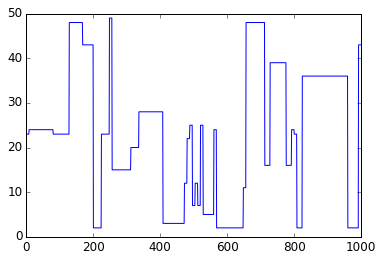

In [9]:
plt.plot(dtraj[0])
plt.xlim([0,1000])

Try building a MSM
------------

In [10]:
print len(dtrajs)
print dtrajs[0].shape

1000
(30006,)


In [11]:
lags = np.linspace(1,150,30,dtype=int)
#lags = np.linspace(tica_lag,8*tica_lag,tica_lag,dtype=int)
print lags
its_full = msm.timescales_msm(dtrajs, lags=lags, nits=6)

[  1   6  11  16  21  26  31  36  42  47  52  57  62  67  72  78  83  88
  93  98 103 108 114 119 124 129 134 139 144 150]


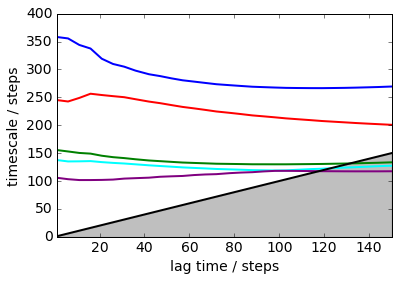

In [12]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its_full, ylog=False, units='steps', linewidth=2)
#xlim(0, 10); ylim(0, 100);

In [13]:
tau_CG = lags[8]
model_nr = np.where(lags==tau_CG)[0][0]
print its_full.lags[model_nr]

42


In [14]:
Tmle_full = its_full.models[model_nr].transition_matrix
mle_full = pyemma.msm.markov_model(Tmle_full)
evals_mle_full = mle_full.eigenvalues(k=15)
evecs_mle_full = mle_full.eigenvectors_left(k=15)
for i in range(2):
    if evecs_mle_full[i][0] < 0:
        evecs_mle_full[i] *= -1

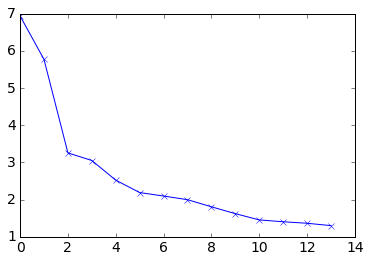

In [15]:
its_full
plt.plot(-1./np.log(evals_mle_full[1:]),marker='x')

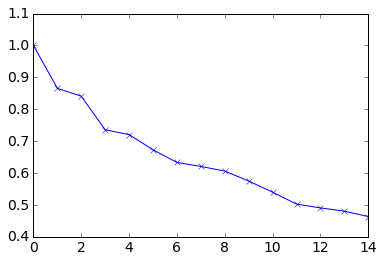

In [16]:
plt.plot(evals_mle_full,marker='x')

/home/theorie/rudzinski/soft/anaconda/envs/PyEmma-new/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/theorie/rudzinski/soft/anaconda/envs/PyEmma-new/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


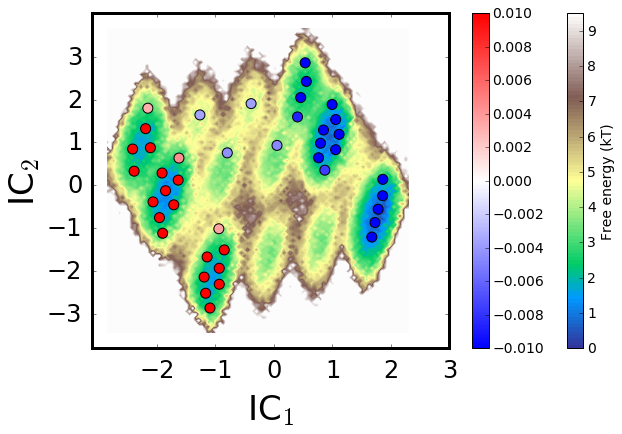

In [28]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
#
kBT = 0.4

fig, ax = mplt.plot_free_energy(np.vstack(Y[0])[:,0], np.vstack(Y[0])[:,1],cmap='terrain')
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
imp_states = np.where(np.abs(evecs_mle_full[1])>0.003)[0]
plt.scatter(cc_x[imp_states],cc_y[imp_states],c=evecs_mle_full[1][imp_states],s=100,cmap='bwr',vmin=-0.01,vmax=0.01) #, markerfacecolor='none')
plt.colorbar()
#
ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)
plt.ylabel(r'IC$_2$',fontsize='34',fontweight='normal')
plt.xlabel(r'IC$_1$',fontsize='34',labelpad=10)
plt.yticks(np.arange(7)*1-3,fontsize='24')
plt.xticks(np.arange(6)*1-2,fontsize='24')
ax.tick_params(axis='both', which='major', pad=10)
# legend
#plt.legend()
#legend = plt.legend(fontsize='26',loc='upper center', bbox_to_anchor=(1.18, 1.1))
#frame = legend.get_frame()
#frame.set_linewidth('3.0')
#ltext = legend.get_texts()
#plt.setp(ltext, fontweight='normal')
#
# plt.ylim([extent[0],extent[1]])
# plt.xlim([extent[2],extent[3]])
# plt.savefig('fig_IC23_2Hstates.svg', format='svg', dpi=800)
# plt.savefig('fig_IC23_2Hstates.eps', format='eps', dpi=800)
plt.show()

In [29]:
# look for N_mss that "work" with PCCA+, i.e., where all mss's are assigned states

# for crisp assignment
N_mss = (np.arange(7)+2).tolist()
mss = []
ndel = 0
for ind,nstate in enumerate(N_mss):
    pcca = msm.PCCA(Tmle_full,nstate)
    membership = pcca.memberships
    mss_assign = pcca.metastable_assignment
    if (np.unique(mss_assign).shape[0]==nstate):
        print nstate
        mss.append(mss_assign)
    else:
        N_mss = np.delete(N_mss,[ind-ndel])
        ndel += 1

2
3
4
5
6
8


In [30]:
# for cored assignment
# memb_cut = []
# memb_frac = 0.85
# ndel = 0
# for ind,nstate in enumerate(N_mss):
#     pcca = msm.PCCA(Tmle_full,nstate)
#     membership = pcca.memberships
#     memb_cut.append( memb_frac*np.max(membership,axis=0) )
#     flag_memb = True
#     for state in range(nstate):
#         if ( len(np.where(membership[:,state] > memb_cut[ind][state])[0]) == 0 ):
#             flag_memb = False
#     if ( flag_memb ):
#         print nstate
#     else:
#         N_mss = np.delete(N_mss,[ind-ndel])
#         memb_cut = np.delete(memb_cut,[ind-ndel])
#         ndel += 1

In [31]:
N_mss

array([2, 3, 4, 5, 6, 8])

In [32]:
mss_sets = []
for nstate in range(len(N_mss)):
    mss_sets.append([])
    for state in range(N_mss[nstate]):
        #for crisp assignment
        mss_sets[nstate].append(np.where(mss[nstate]==state)[0])
        #for cored assignment
#         pcca = msm.PCCA(Tmle_full,N_mss[nstate])
#         membership = pcca.memberships
#         mss_sets[nstate].append( np.where(membership[:,state] > memb_cut[nstate][state])[0] )

In [33]:
# check for state overlaps and, if so, simply remove the overlapping state from both sets
for nstate in range(len(N_mss)):
    for statei in range(N_mss[nstate]):
        for statej in range(statei+1,N_mss[nstate]):
            intersect = np.intersect1d(mss_sets[nstate][statei],mss_sets[nstate][statej])
            if ( intersect.shape[0] != 0 ):
                overlap_pos_i = np.array([])
                overlap_pos_j = np.array([])
                for overlap in np.intersect1d(mss_sets[nstate][statei],mss_sets[nstate][statej]):
                    overlap_pos_i = np.hstack((overlap_pos_i,np.where(mss_sets[nstate][statei]==overlap)[0]))
                    overlap_pos_j = np.hstack((overlap_pos_j,np.where(mss_sets[nstate][statej]==overlap)[0]))
                mss_sets[nstate][statei] = np.delete(mss_sets[nstate][statei],overlap_pos_i)
                mss_sets[nstate][statej] = np.delete(mss_sets[nstate][statej],overlap_pos_j)
                print 'overlap between state '+str(statei)+' and state '+str(statej)+' of mss '+str(nstate)
                print 'removed states '+str(intersect)

In [34]:
# define the color schemes for the mss_sets
from matplotlib.pyplot import *
mycmap = plt.cm.rainbow
mss_colors = []
for nstate in range(len(N_mss)):
    mycmap_max = N_mss[nstate]
    mycmap_min = 0
    # extract all colors from the map
    mycmaplist = [mycmap(i) for i in range(mycmap.N)]
    # create the new map
    mycmap = mycmap.from_list('Custom cmap', mycmaplist, mycmap.N)
    # define the bins and normalize
    bounds = np.linspace(mycmap_min,mycmap_max,mycmap.N)
    norm = matplotlib.colors.BoundaryNorm(bounds, mycmap.N)
    mycmaplist = [mycmap(i) for i in range(mycmap.N)]
    dx = bounds[1] - bounds[0]
    mss_colors.append([])
    for state in range(N_mss[nstate]):
        grid = int( (state - mycmap_min)/dx + 0.5 )
        mss_colors[nstate].append(mycmaplist[grid])

2 metastable states:


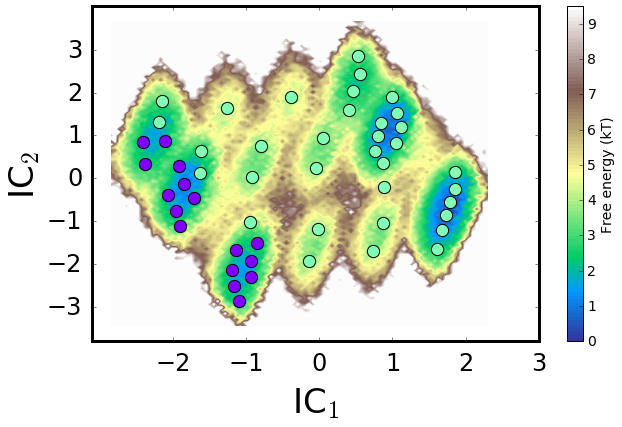

3 metastable states:


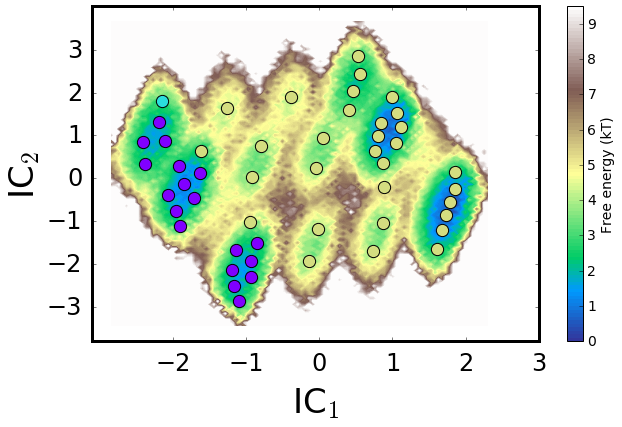

4 metastable states:


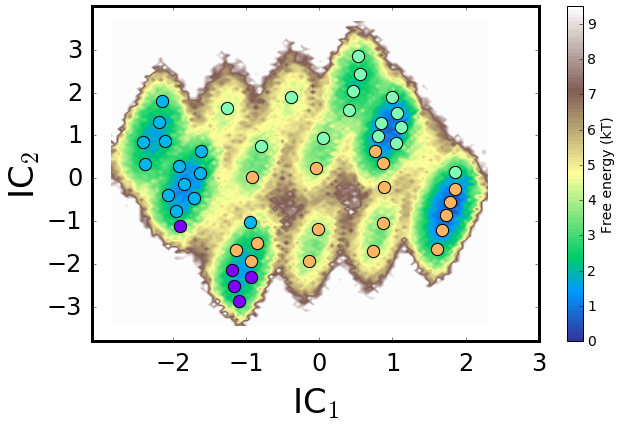

5 metastable states:


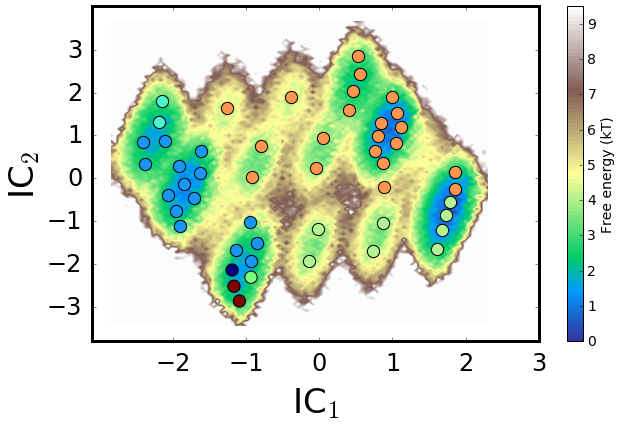

6 metastable states:


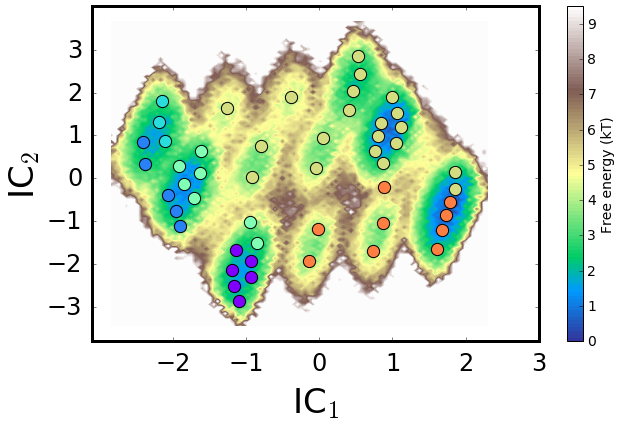

8 metastable states:


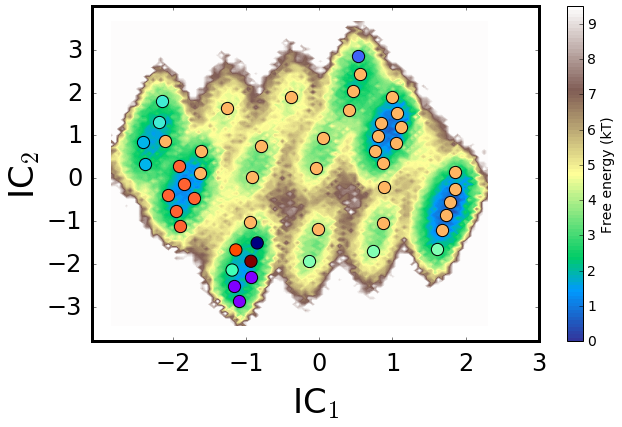

In [35]:
for nstate in range(len(N_mss)):
    print str(N_mss[nstate])+' metastable states:'

    for dim in range(1):
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111)
        #

        fig, ax = mplt.plot_free_energy(np.vstack(Y[0])[:,0], np.vstack(Y[0])[:,dim+1],cmap='terrain')
        for state in range(N_mss[nstate]):
            cc_x = clustering.clustercenters[:,0]
            cc_y = clustering.clustercenters[:,dim+1]
            plt.scatter(cc_x[mss_sets[nstate][state]],cc_y[mss_sets[nstate][state]],c=mss_colors[nstate][state],s=150)


        # cc_x = clustering.clustercenters[:,0]
        # cc_y = clustering.clustercenters[:,1]
        # plt.scatter(cc_x,cc_y,c=evecs_mle_full[1],s=100,cmap='bwr',vmin=-0.07,vmax=0.07) #, markerfacecolor='none')
        # plt.colorbar()
        #
        ax.spines['left'].set_linewidth(3.0)
        ax.spines['right'].set_linewidth(3.0)
        ax.spines['top'].set_linewidth(3.0)
        ax.spines['bottom'].set_linewidth(3.0)
        plt.ylabel(r'IC$_2$',fontsize='34',fontweight='normal')
        plt.xlabel(r'IC$_1$',fontsize='34',labelpad=10)
        plt.yticks(np.arange(7)*1-3,fontsize='24')
        plt.xticks(np.arange(6)*1-2,fontsize='24')
        ax.tick_params(axis='both', which='major', pad=10)
        # legend
        #plt.legend()
        #legend = plt.legend(fontsize='26',loc='upper center', bbox_to_anchor=(1.18, 1.1))
        #frame = legend.get_frame()
        #frame.set_linewidth('3.0')
        #ltext = legend.get_texts()
        #plt.setp(ltext, fontweight='normal')
        #
        # plt.ylim([extent[0],extent[1]])
        # plt.xlim([extent[2],extent[3]])
        # plt.savefig('fig_IC23_2Hstates.svg', format='svg', dpi=800)
        # plt.savefig('fig_IC23_2Hstates.eps', format='eps', dpi=800)
        plt.show()

In [36]:
# save the mss definitions
for nstate in range(len(N_mss)):
    np.save('mss_sets_'+str(N_mss[nstate])+'states',mss_sets[nstate])
np.save('tau_CG',tau_CG)

In [37]:
# transform dtraj to the mss's
# first get the map
mss_map = []
for nstate in range(len(N_mss)):
    mss_map.append([])
    for micro in range(np.unique(dtrajs).shape[0]):
        new_state = -1
        for state in range(N_mss[nstate]):
            if ( np.where(mss_sets[nstate][state]==micro)[0].shape[0] != 0 ):
                new_state = state
                break
        mss_map[nstate].append(new_state)
    mss_map[nstate] = np.array(mss_map[nstate])

In [ ]:
# now apply the map and save
for nstate in range(len(N_mss)):
    dtraj_mss_concat = []
    for traj in range(len(dtrajs)):
        dtraj_mss_concat = np.hstack((dtraj_mss_concat,mss_map[nstate][dtrajs[traj]]))
    np.savetxt('dtraj_mss_concat_'+str(N_mss[nstate])+'states.dat',dtraj_mss_concat.astype(int),fmt='%d')
np.savetxt('dtraj_mss_traj_len.dat',[dtrajs[0].shape[0]])

In [ ]:
# Let's try using the cored trajs and only for the partitioning that I care about

In [38]:
N_mss_cut = np.array([2,6])

In [39]:
dtrajs_cored = []
dtrajs_cored.append(np.load('2states/msds/dtraj_mss_2states_cored.npy'))
dtrajs_cored.append(np.load('6states/msds/dtraj_mss_6states_cored.npy'))

In [40]:
lag = tica_lag

In [41]:
# load the relevant rdf data
rdfs_nm = ['BB','AB']
cent_nm = [ '', 'B']
rdf_dir = '/data/isilon/rudzinski/cluster_tmp/LJ/Kobb_Andersen/DiffCoeff_red-dt_30ns/T0.4/MSM_analysis/2016_12-Dec_13/step1-dtraj_mpi/'
data_rdf = []
sel = []
pairs_excl = []
r = []
gr = []
N_solshel = []
solshel_max = []
sig = []
rcut = []
weight = []
for rdf in range(len(rdfs_nm)):
    sys = rdfs_nm[rdf]
    data_rdf = np.load(rdf_dir+'data_'+sys+'_rdf.npz')
    sel.append(data_rdf['sel'])
    pairs_excl.append(data_rdf['pairs_excl'])
    r.append(data_rdf['r'])
    gr.append(data_rdf['gr'])
    N_solshel.append(data_rdf['N_solshel'])
    solshel_max.append(data_rdf['solshel_max'])
    sig.append(data_rdf['sig'])
    rcut.append(data_rdf['rcut'])
    weight.append(data_rdf['weight'])

In [42]:
# sort the dtraj by mss
indir_CN = '/data/isilon/rudzinski/cluster_tmp/LJ/Kobb_Andersen/DiffCoeff_red-dt_30ns/T0.4/MSM_analysis/2016_12-Dec_13/step1-dtraj_mpi/'

# first get the dtrajs
Xre = []
for rdf in range(len(rdfs_nm)):
    Xre.append([])
    pair_type = rdfs_nm[rdf]
    if (pair_type == 'AB'):
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_0-5ns.npz')
        Xre[rdf] = dtraj_CNs['Xre_'+cent_nm[rdf]]
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_5-10ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre_'+cent_nm[rdf]]))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_10-15ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre_'+cent_nm[rdf]]))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_15-20ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre_'+cent_nm[rdf]]))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_20-25ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre_'+cent_nm[rdf]]))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_25-30ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre_'+cent_nm[rdf]]))
    else:
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_0-5ns.npz')
        Xre[rdf] = dtraj_CNs['Xre']
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_5-10ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre']))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_10-15ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre']))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_15-20ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre']))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_20-25ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre']))
        dtraj_CNs = np.load(indir_CN+'/dtraj_CNs_'+pair_type+'_25-30ns.npz')
        Xre[rdf] = np.hstack((Xre[rdf],dtraj_CNs['Xre']))
        
# now organize per mss
# CN_rdf = []
# avg_CN = []
# for nstate in range(len(N_mss)):
#     CN_rdf.append([])
#     avg_CN.append([])
#     for rdf in range(len(rdfs_nm)):
#         CN_rdf[nstate].append([])
#         avg_CN[nstate].append([])
#         for shell in range(N_solshel[rdf]):
#             CN_rdf[nstate][rdf].append([[] for x in range(N_mss[nstate])])
#             avg_CN[nstate][rdf].append(np.zeros(N_mss[nstate]))
#             for traj in range(len(Xre[rdf])):
#                 CN_tmp = Xre[rdf][traj][::Nprune*lag,shell]
#                 for state in range( N_mss[nstate] ):
#                     state_frs = np.array([])
#                     for micro in mss_sets[nstate][state]:
#                         state_frs = np.hstack( (state_frs,np.where(dtrajs[traj] == micro)[0]) )
#                     if ( len(state_frs) != 0 ):
#                         CN_rdf[nstate][rdf][shell][state] = np.hstack((CN_rdf[nstate][rdf][shell][state],CN_tmp[state_frs.astype(int)]))
#             for state in range( N_mss[nstate] ):
#                 avg_CN[nstate][rdf][shell][state] = np.mean( CN_rdf[nstate][rdf][shell][state] )    
                
# now organize per mss using the cored trajs
CN_rdf = []
avg_CN = []
for nstate in range(len(N_mss_cut)):
    CN_rdf.append([])
    avg_CN.append([])
    for rdf in range(len(rdfs_nm)):
        CN_rdf[nstate].append([])
        avg_CN[nstate].append([])
        for shell in range(N_solshel[rdf]):
            CN_rdf[nstate][rdf].append([[] for x in range(N_mss_cut[nstate])])
            avg_CN[nstate][rdf].append(np.zeros(N_mss_cut[nstate]))
            for traj in range(len(Xre[rdf])):
                CN_tmp = Xre[rdf][traj][::Nprune*lag,shell]
                for state in range( N_mss_cut[nstate] ):
                    state_frs = np.where(dtrajs_cored[nstate][traj] == state)[0]
                    if ( len(state_frs) != 0 ):
                        CN_rdf[nstate][rdf][shell][state] = np.hstack((CN_rdf[nstate][rdf][shell][state],CN_tmp[state_frs.astype(int)]))
            for state in range( N_mss_cut[nstate] ):
                avg_CN[nstate][rdf][shell][state] = np.mean( CN_rdf[nstate][rdf][shell][state] )    

In [43]:
np.save('CN_rdf',CN_rdf)
np.save('avg_CN', avg_CN)

In [80]:
# now get the averages for each mss and feat
# n_feat = 0
# avg_CN = []
# for nstate in range(len(N_mss)):
#     avg_CN.append([])
#     for rdfs in range(len(rdfs_nm)):
#         avg_CN[nstate].append([])
#         for feat in range(N_solshel[rdfs]):
#             avg_CN[nstate][rdfs].append([])
#             for state in range(N_mss[nstate]):
#                 avg_CN[nstate][rdfs][feat].append( np.mean(np.array(CN_rdf[rdfs][feat])[state]) )
#             n_feat += 1

3 metastable states:
rdf-0 feat-2


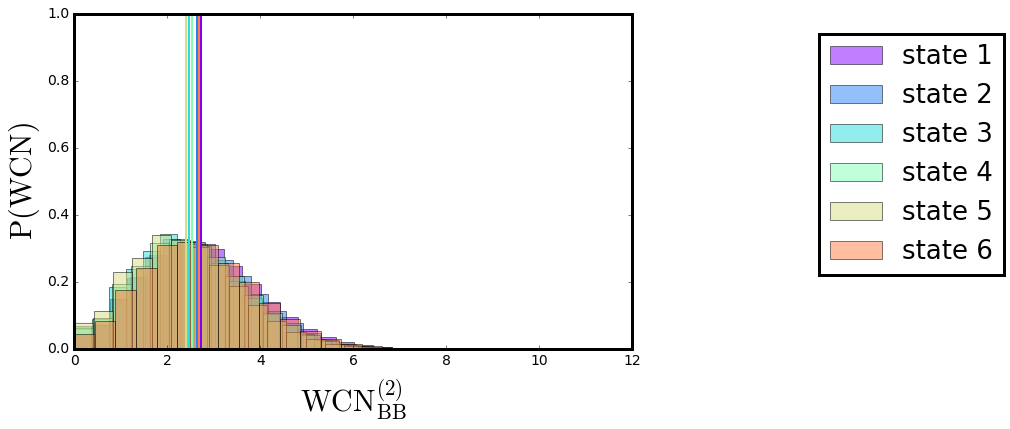

In [91]:
nstate = 1
print str(N_mss[nstate])+' metastable states:'
rdfs = 0
feat = 2
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss_cut[nstate]):
    label = 'state '+str(state+1)
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[4][state], label=label )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[4][state],linewidth=2)

ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

# legend
plt.legend()
legend = plt.legend(fontsize='26',loc='upper center', bbox_to_anchor=(1.5, 0.98))
frame = legend.get_frame()
frame.set_linewidth('3.0')
ltext = legend.get_texts()
plt.setp(ltext, fontweight='normal')

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm BB}^{(2)}$',fontsize='30',labelpad=10)

# plt.yticks(np.arange(10)*0.1,fontsize='20')
# plt.xticks(np.arange(8),fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

# plt.ylim([0.,0.5])
# plt.xlim([0,7.25])

2 metastable states:
rdf-0 feat-1


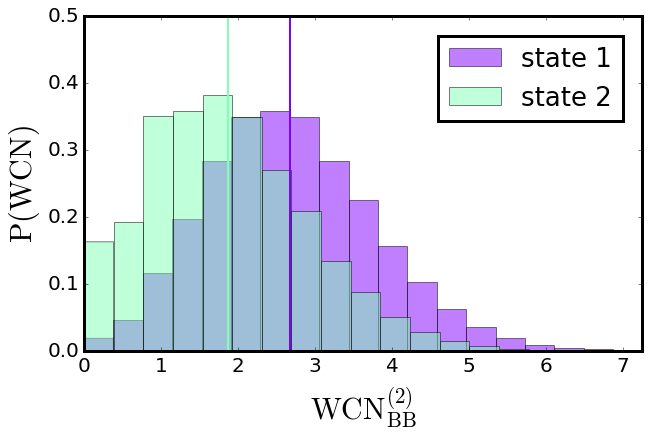

rdf-0 feat-4


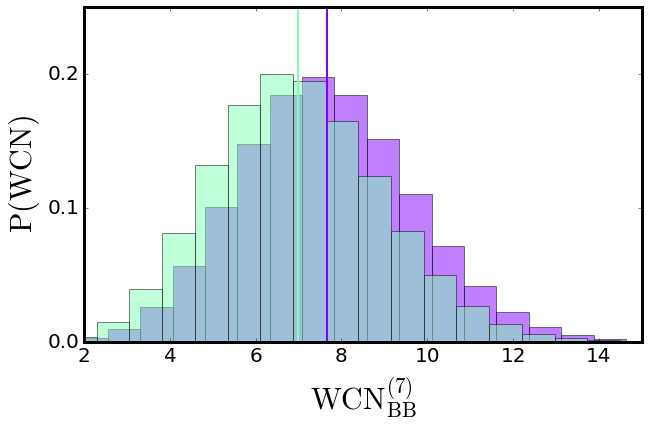

rdf-1 feat-0


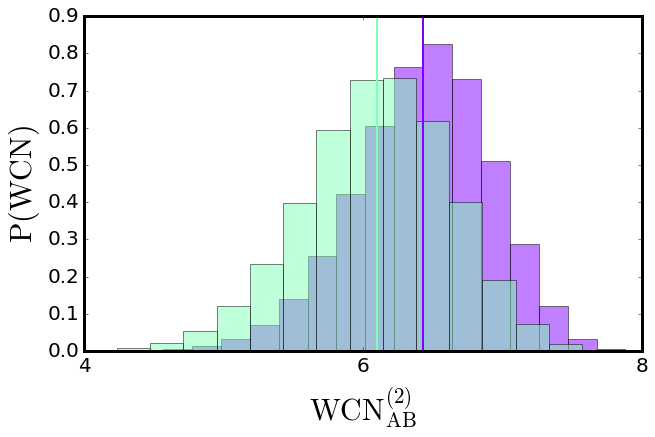

rdf-1 feat-1


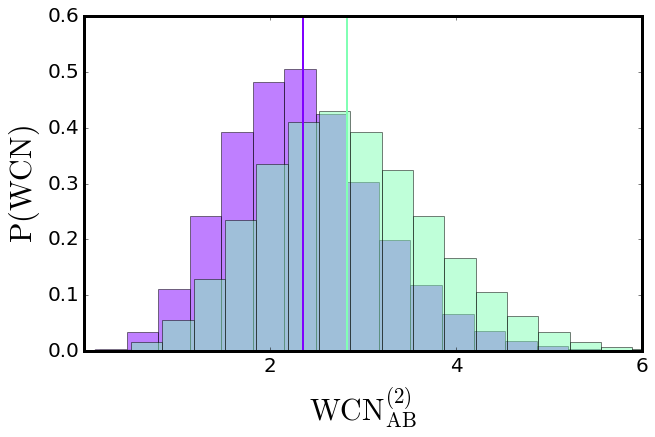

6 metastable states:
rdf-0 feat-1


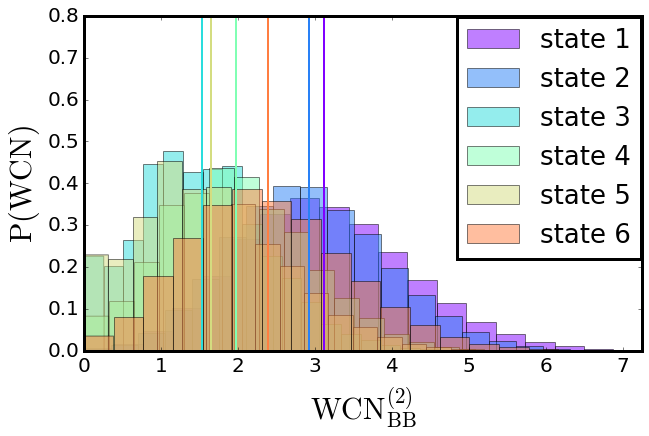

rdf-0 feat-4


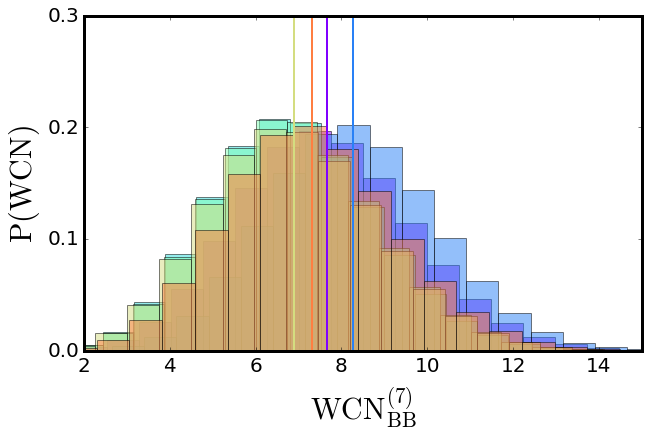

rdf-1 feat-0


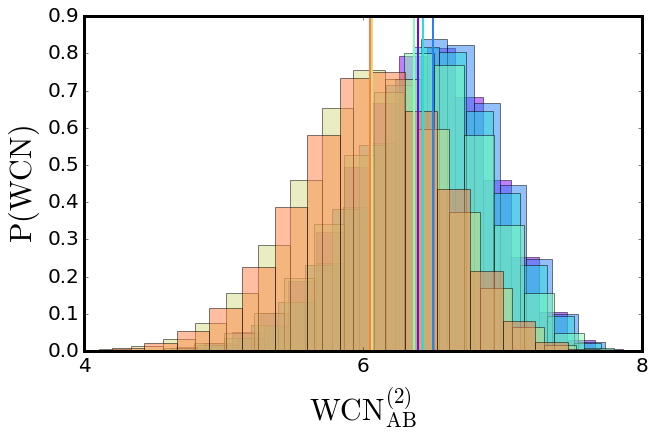

rdf-1 feat-1


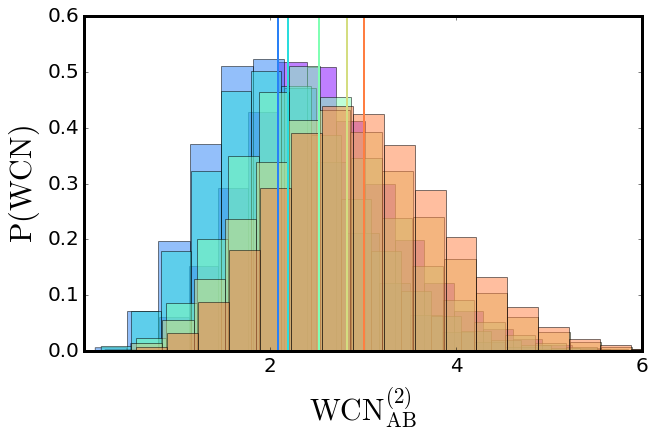

In [60]:
# everything by hand for Figs
nstate = 0
print str(N_mss[nstate])+' metastable states:'
rdfs = 0
feat = 1
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    label = 'state '+str(state+1)
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state], label=label )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

# legend
plt.legend()
legend = plt.legend(fontsize='26',loc='upper center', bbox_to_anchor=(0.8, 0.98))
frame = legend.get_frame()
frame.set_linewidth('3.0')
ltext = legend.get_texts()
plt.setp(ltext, fontweight='normal')

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm BB}^{(2)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8),fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.5])
plt.xlim([0,7.25])

plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)
    
plt.show()

feat = 4
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state] )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

    
ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm BB}^{(7)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8)*2+2,fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.25])
plt.xlim([2,15])

plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)

plt.show()

rdfs=1
feat = 0
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state] )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

    
ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm AB}^{(2)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8)*2+2,fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.9])
plt.xlim([4,8])

plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)

plt.show()

rdfs=1
feat = 1
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state] )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

    
ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm AB}^{(2)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8)*2+2,fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.6])
plt.xlim([0,6])

plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)

plt.show()


nstate = 4
print str(N_mss[nstate])+' metastable states:'
rdfs = 0
feat = 1
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    label = 'state '+str(state+1)
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state], label=label )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

# legend
plt.legend()
legend = plt.legend(fontsize='26',loc='upper center', bbox_to_anchor=(0.833, 1.035))
frame = legend.get_frame()
frame.set_linewidth('3.0')
ltext = legend.get_texts()
plt.setp(ltext, fontweight='normal')

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm BB}^{(2)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8),fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.8])
plt.xlim([0,7.25])

plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)

plt.show()

feat = 4
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state] )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm BB}^{(7)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8)*2+2,fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.3])
plt.xlim([2,15])

plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-BB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)

plt.show()

rdfs=1
feat = 0
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state] )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

    
ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm AB}^{(2)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8)*2+2,fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.9])
plt.xlim([4,8])

plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)

plt.show()

rdfs=1
feat = 1
print 'rdf-'+str(rdfs)+' feat-'+str(feat)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for state in range(N_mss[nstate]):
    tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state] )
    plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,1.,10),color=mss_colors[nstate][state],linewidth=2)

    
ax.spines['left'].set_linewidth(3.0)
ax.spines['right'].set_linewidth(3.0)
ax.spines['top'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='30',fontweight='normal')
plt.xlabel(r'${\rm WCN}_{\rm AB}^{(2)}$',fontsize='30',labelpad=10)

plt.yticks(np.arange(10)*0.1,fontsize='20')
plt.xticks(np.arange(8)*2+2,fontsize='20')
ax.tick_params(axis='both', which='major', pad=5)

plt.ylim([0.,0.6])
plt.xlim([0,6])

plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.svg', format='svg', dpi=800)
plt.savefig('fig_P-WCN-AB-'+str(feat)+'_'+str(N_mss[nstate])+'HstateHMM.eps', format='eps', dpi=800)

plt.show()

2 metastable states:
rdf-0 feat-0


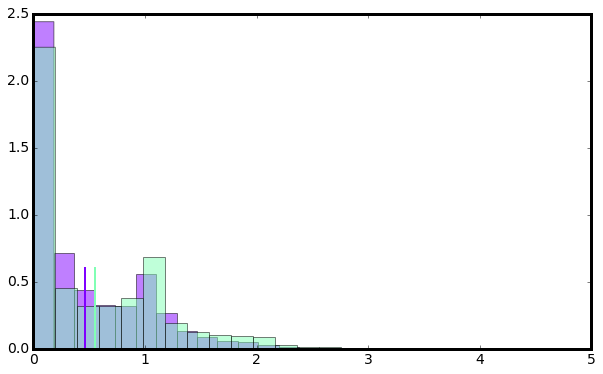

rdf-0 feat-1


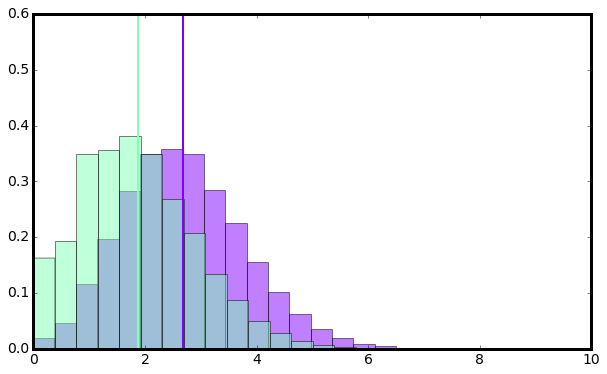

rdf-0 feat-2


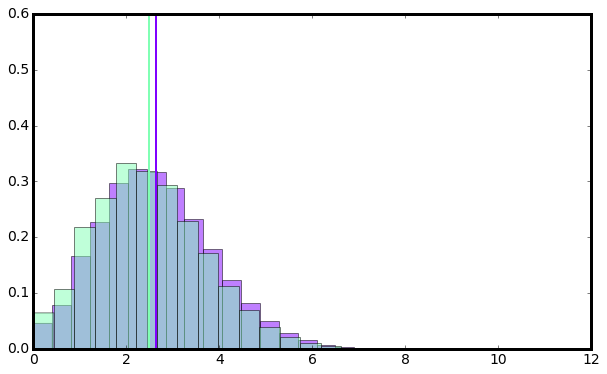

rdf-0 feat-3


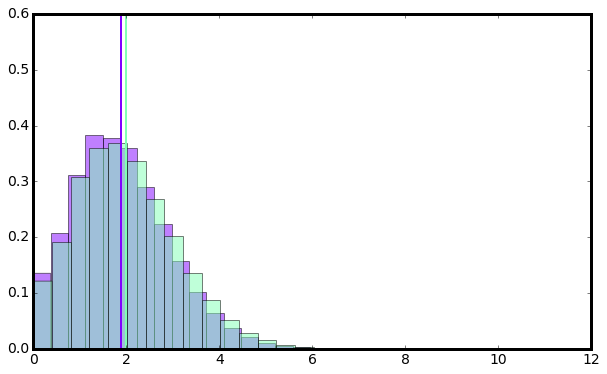

rdf-0 feat-4


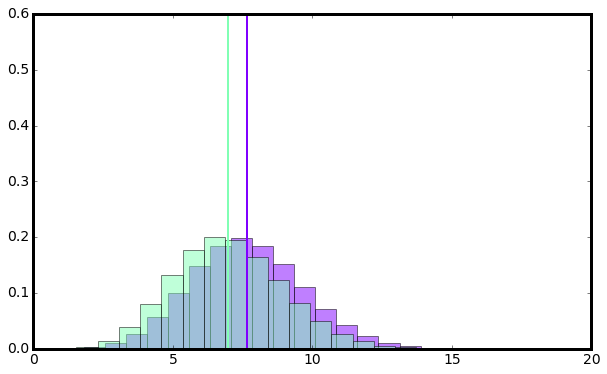

rdf-0 feat-5


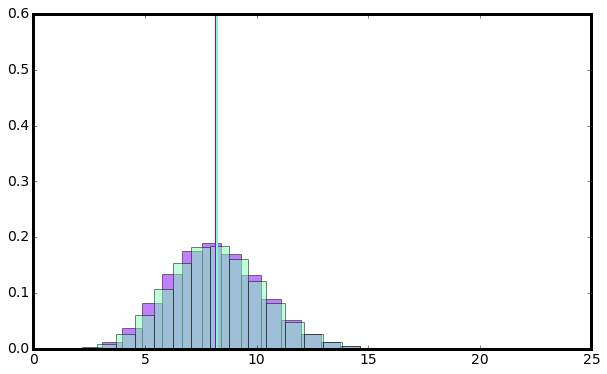

rdf-1 feat-0


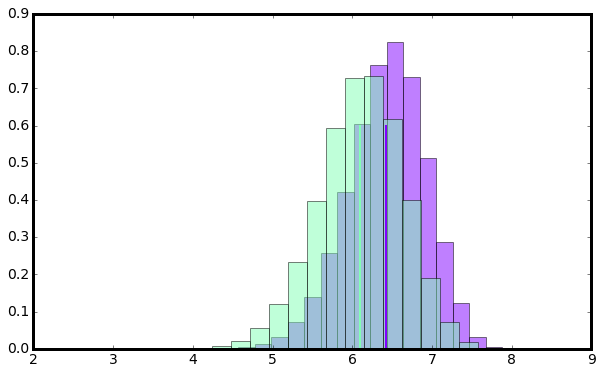

rdf-1 feat-1


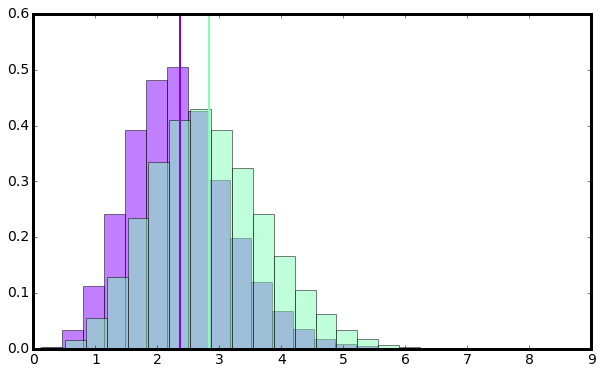

rdf-1 feat-2


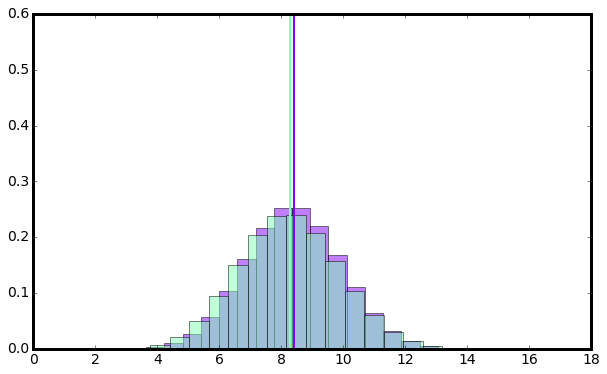

rdf-1 feat-3


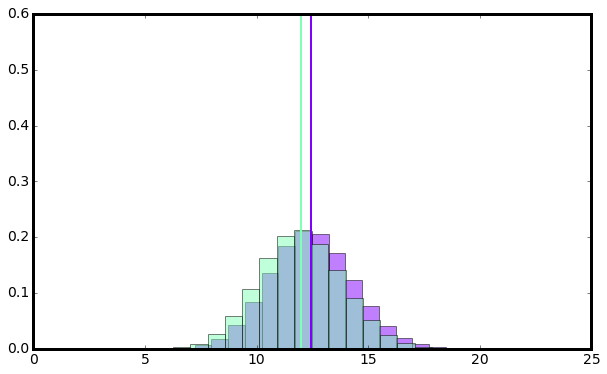

rdf-1 feat-4


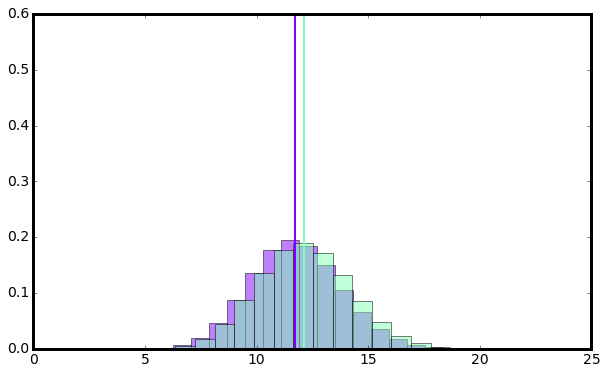

rdf-1 feat-5


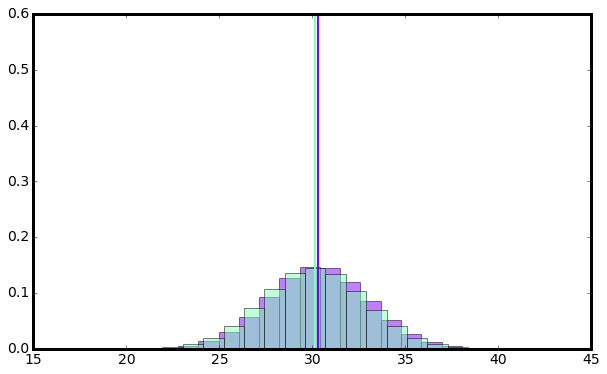

3 metastable states:
rdf-0 feat-0


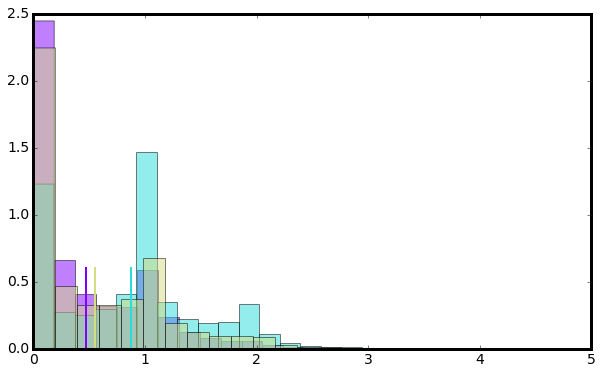

rdf-0 feat-1


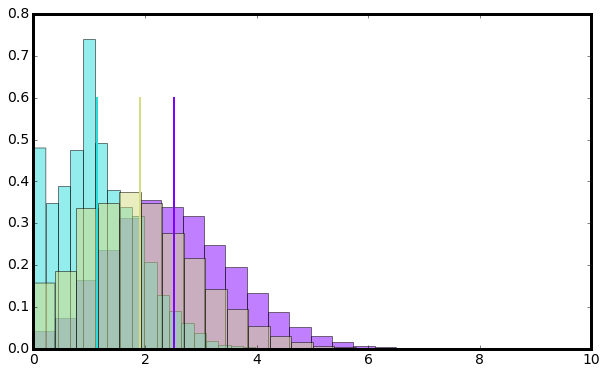

rdf-0 feat-2


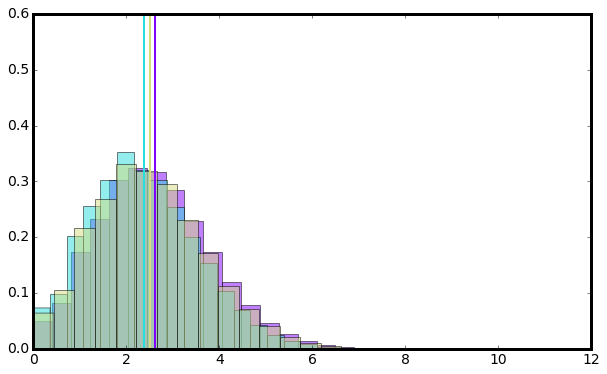

rdf-0 feat-3


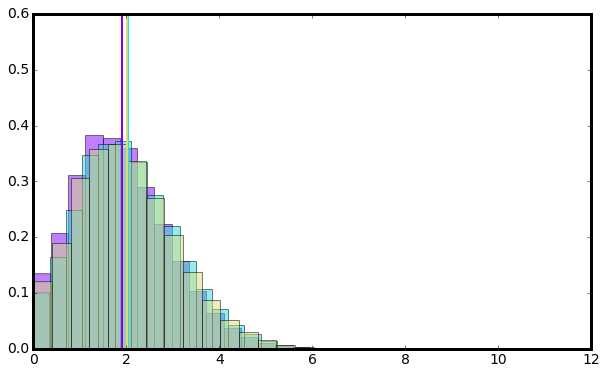

rdf-0 feat-4


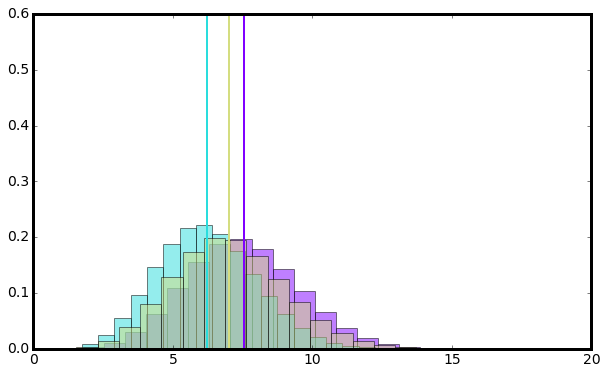

rdf-0 feat-5


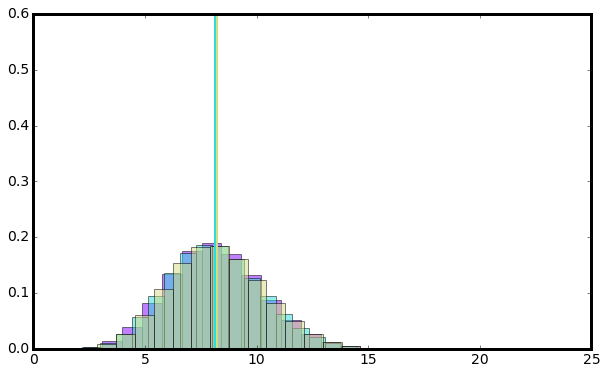

rdf-1 feat-0


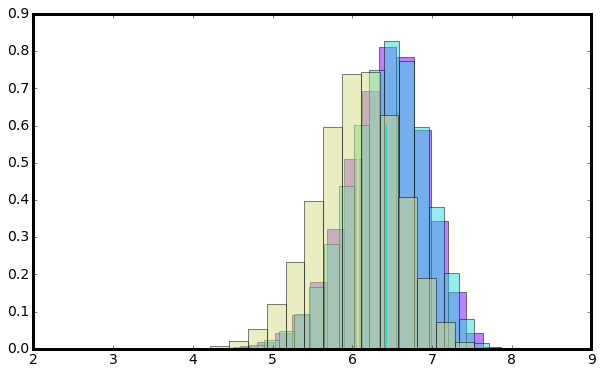

rdf-1 feat-1


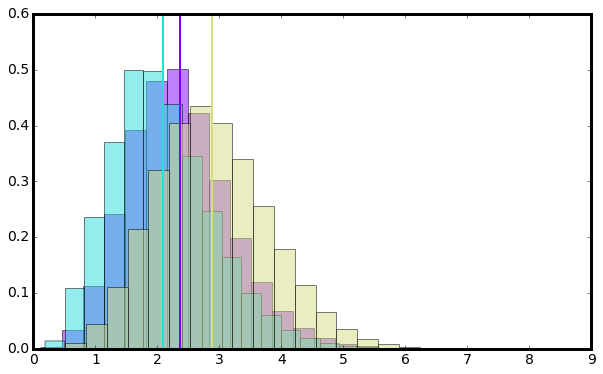

rdf-1 feat-2


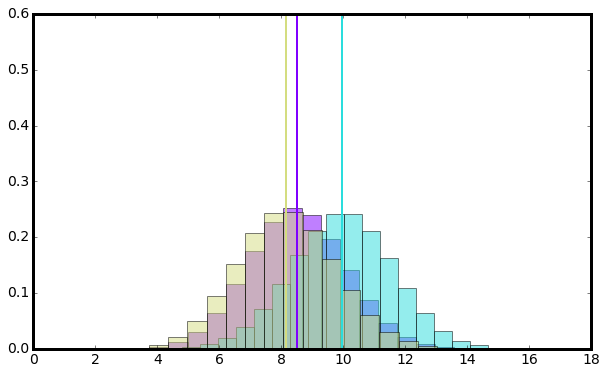

rdf-1 feat-3


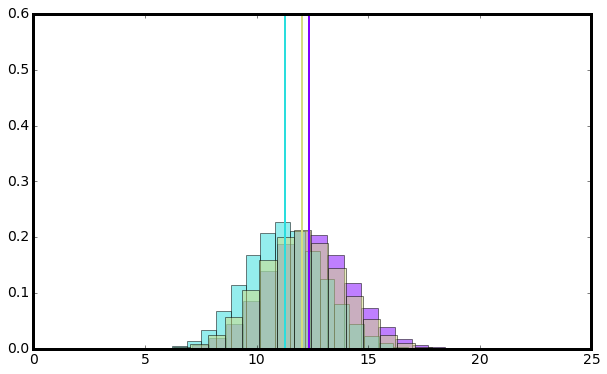

rdf-1 feat-4


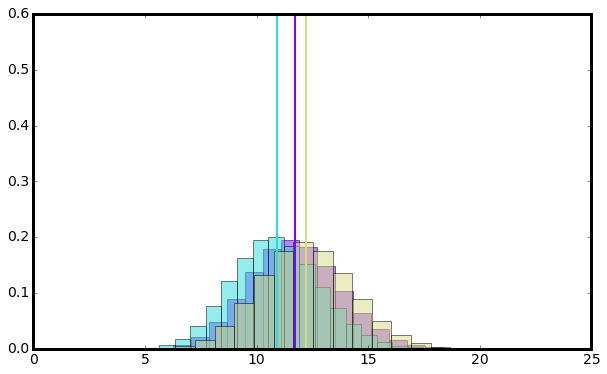

rdf-1 feat-5


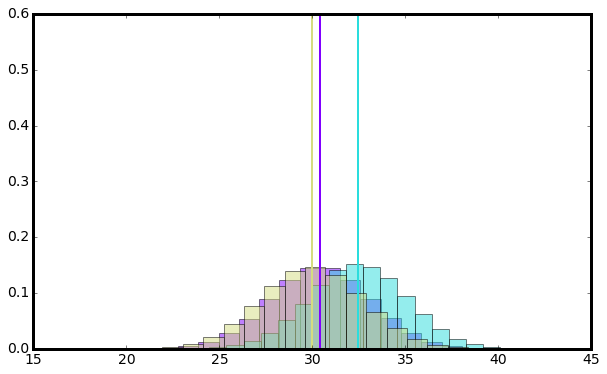

4 metastable states:
rdf-0 feat-0


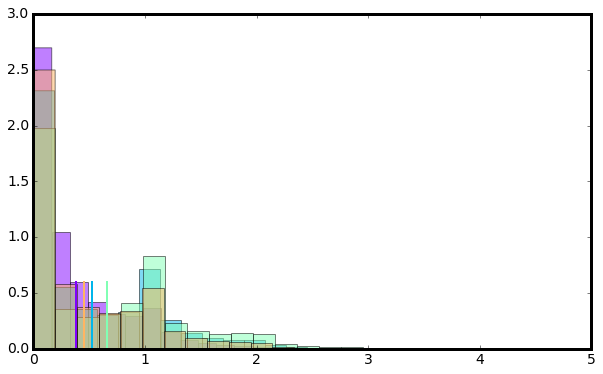

rdf-0 feat-1


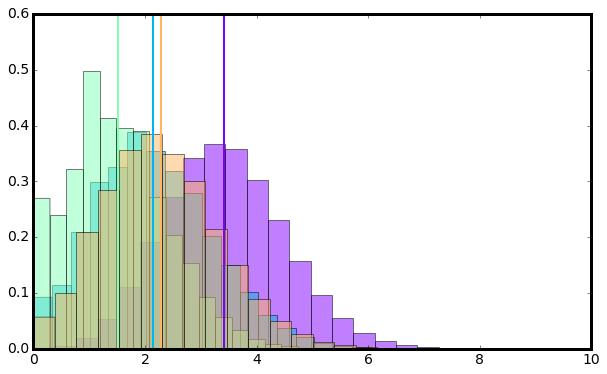

rdf-0 feat-2


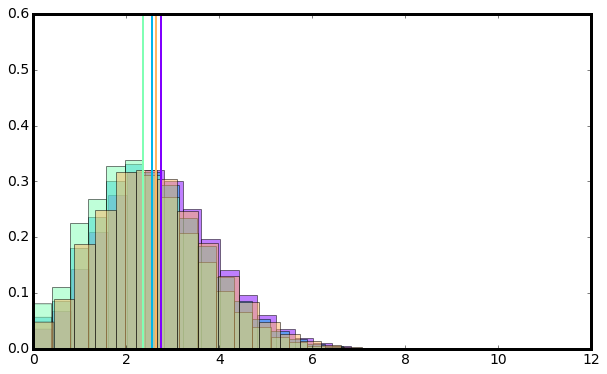

rdf-0 feat-3


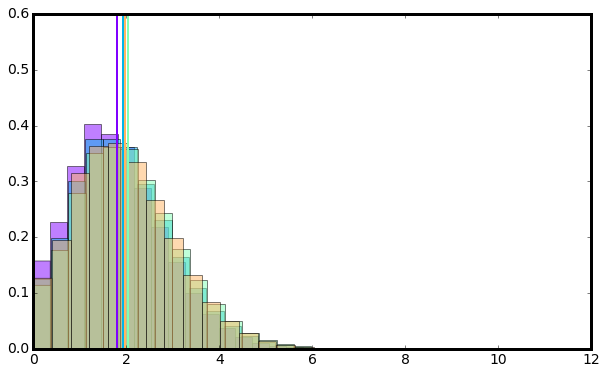

rdf-0 feat-4


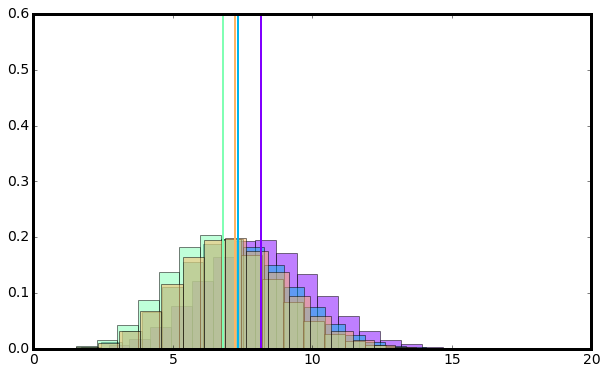

rdf-0 feat-5


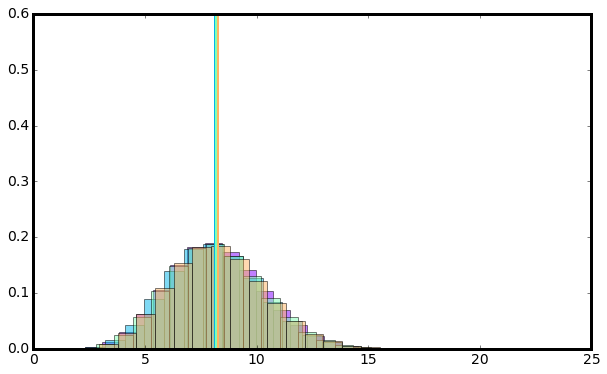

rdf-1 feat-0


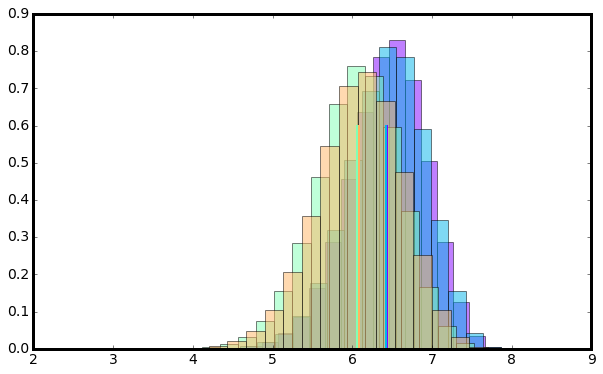

rdf-1 feat-1


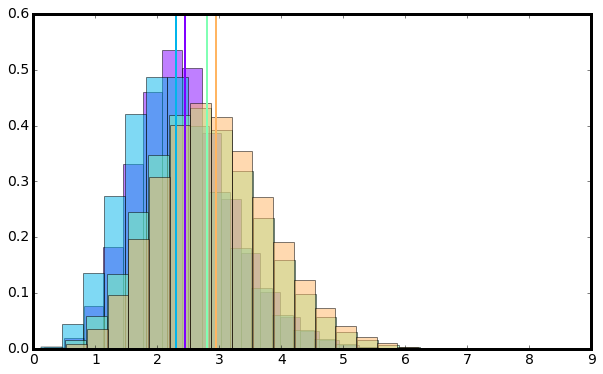

rdf-1 feat-2


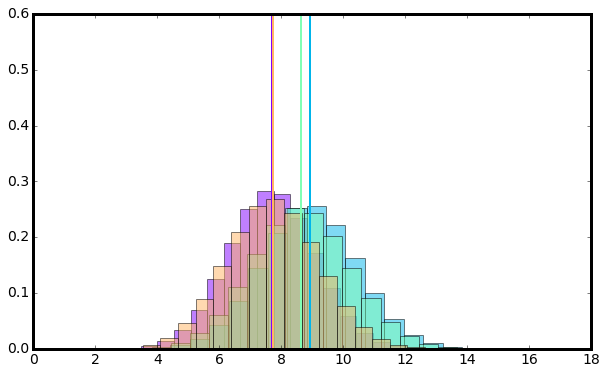

rdf-1 feat-3


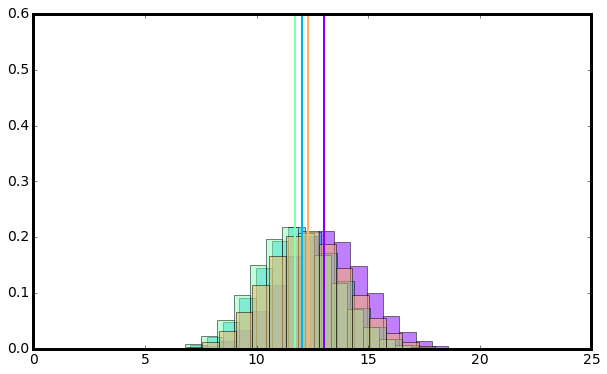

rdf-1 feat-4


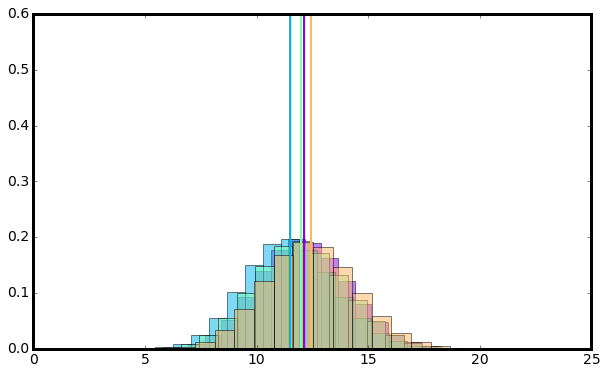

rdf-1 feat-5


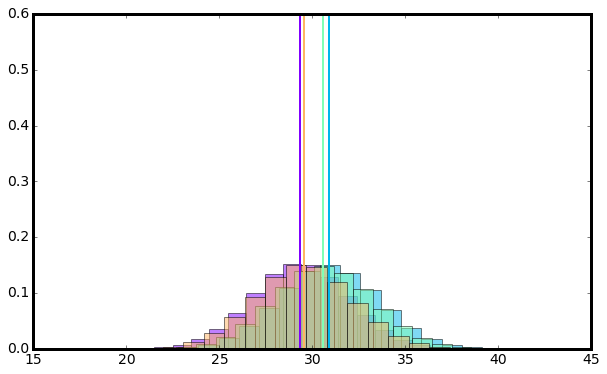

5 metastable states:
rdf-0 feat-0


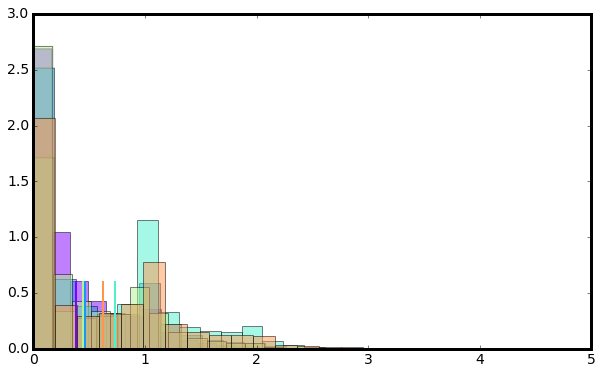

rdf-0 feat-1


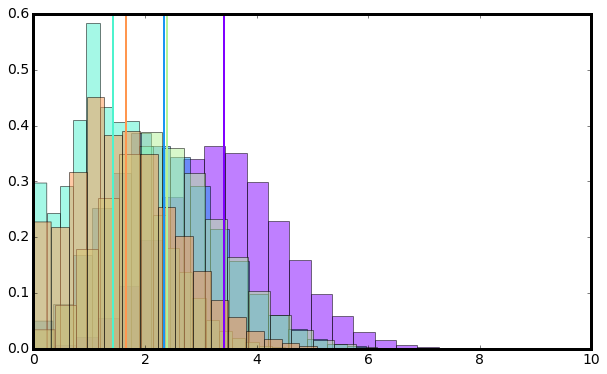

rdf-0 feat-2


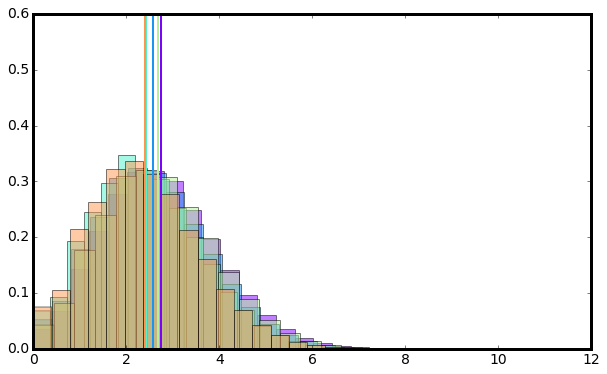

rdf-0 feat-3


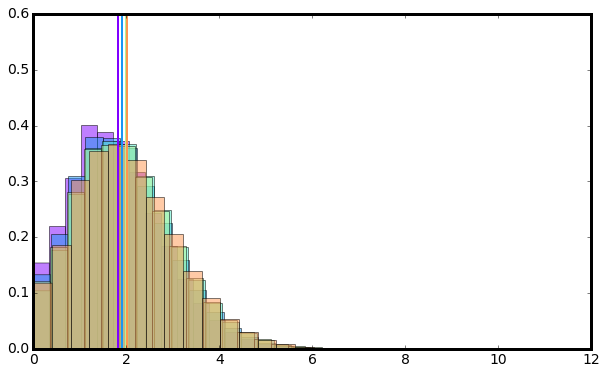

rdf-0 feat-4


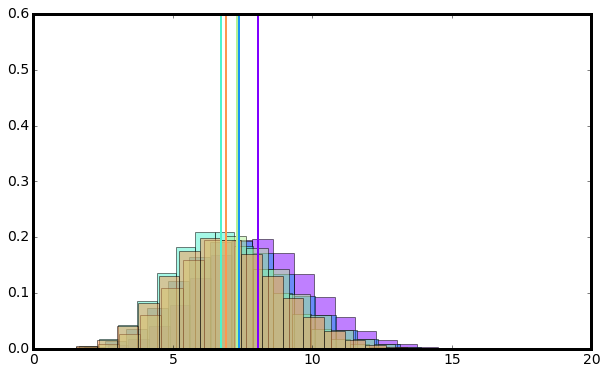

rdf-0 feat-5


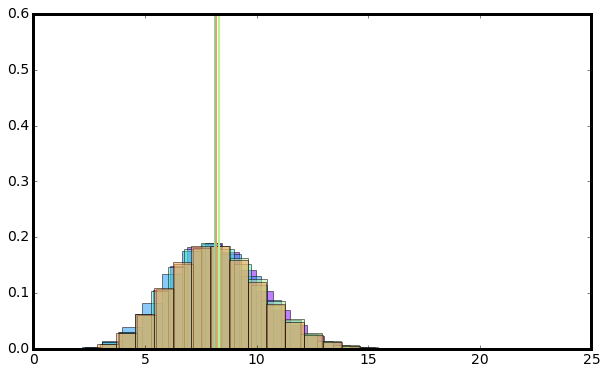

rdf-1 feat-0


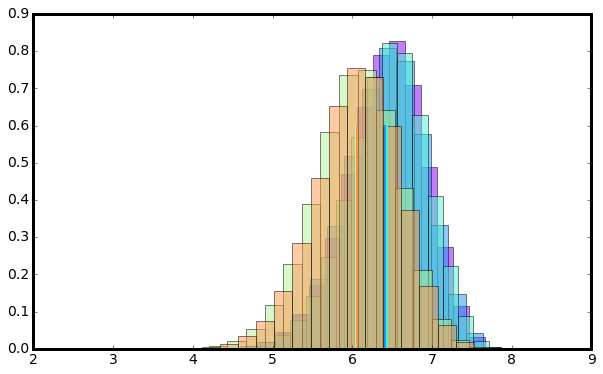

rdf-1 feat-1


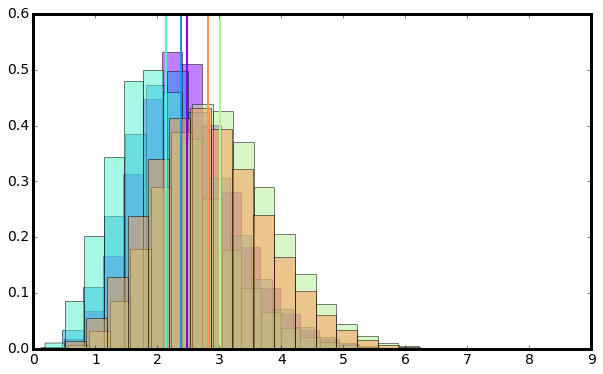

rdf-1 feat-2


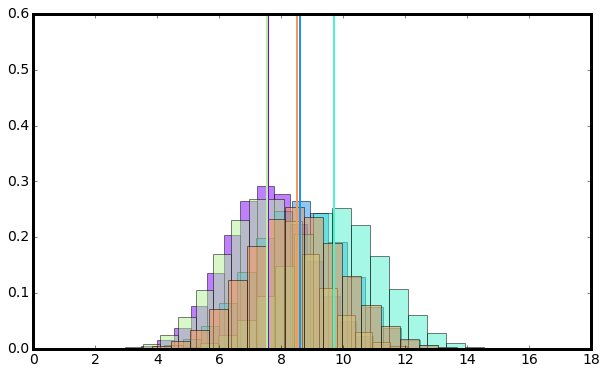

rdf-1 feat-3


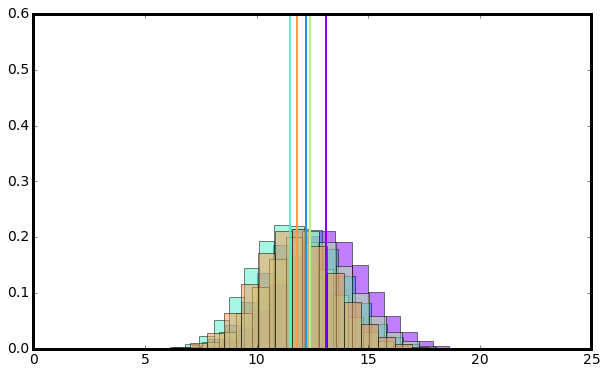

rdf-1 feat-4


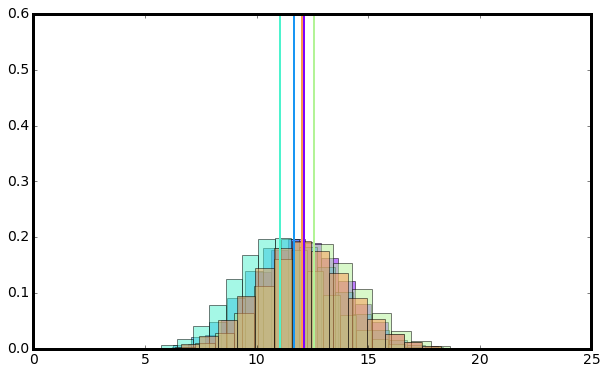

rdf-1 feat-5


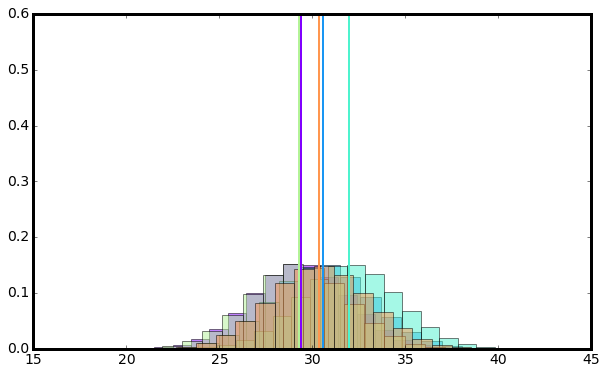

6 metastable states:
rdf-0 feat-0


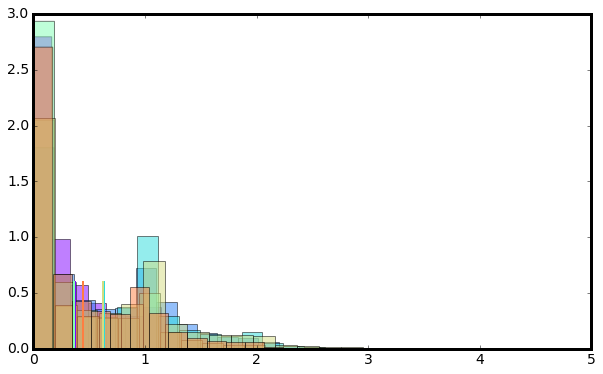

rdf-0 feat-1


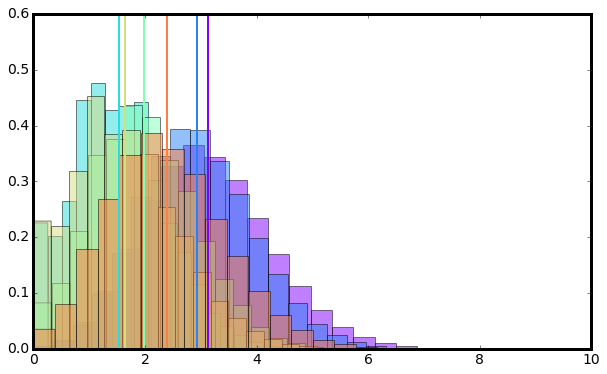

rdf-0 feat-2


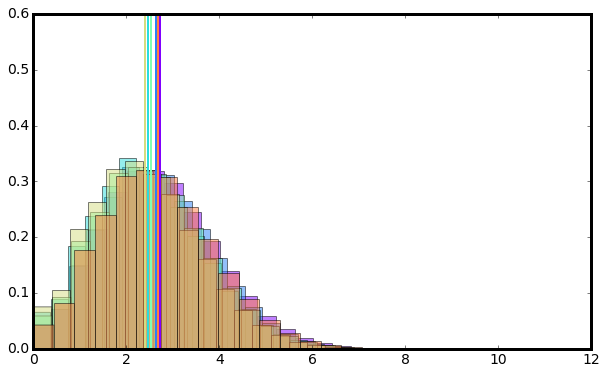

rdf-0 feat-3


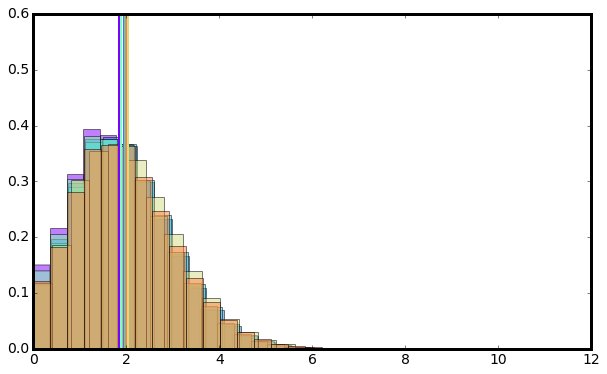

rdf-0 feat-4


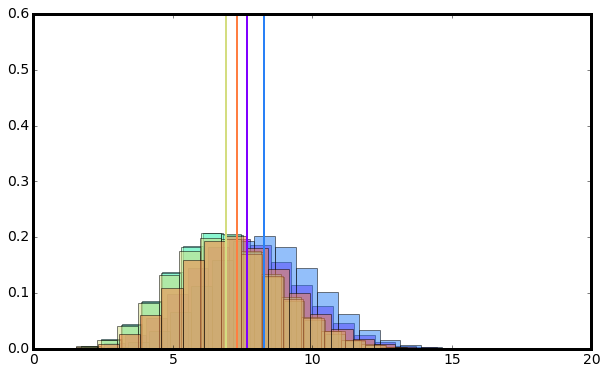

rdf-0 feat-5


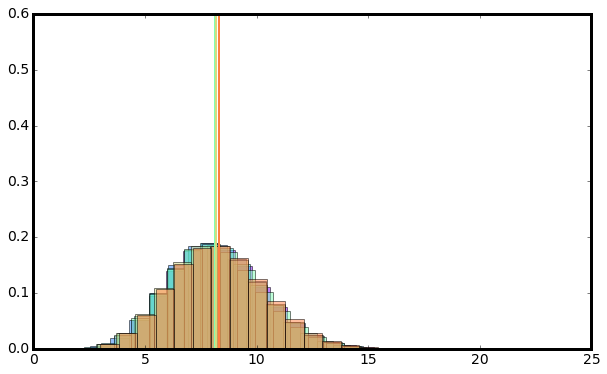

rdf-1 feat-0


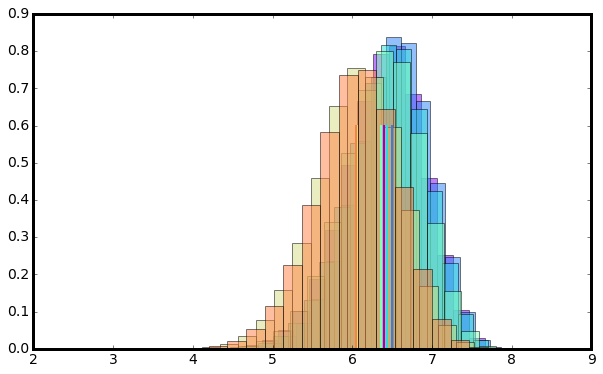

rdf-1 feat-1


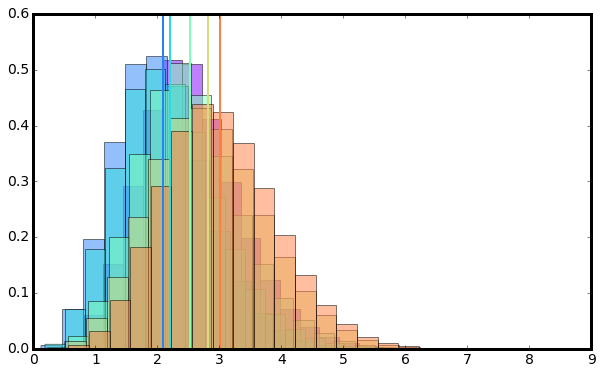

rdf-1 feat-2


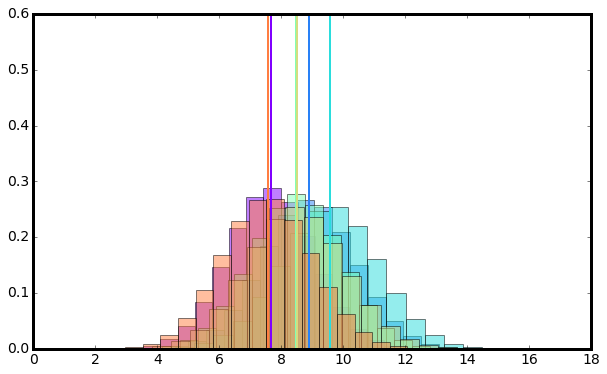

rdf-1 feat-3


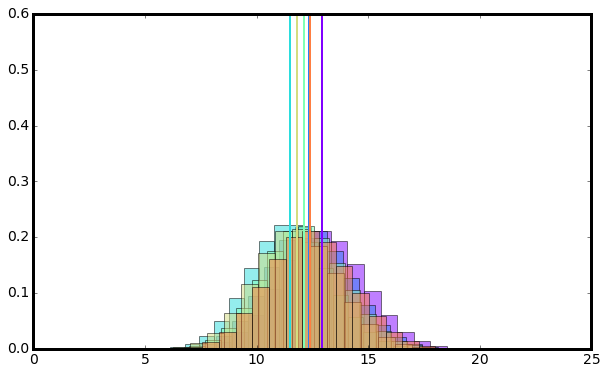

rdf-1 feat-4


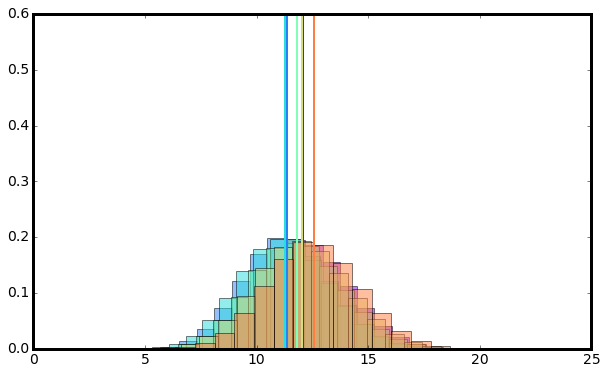

rdf-1 feat-5


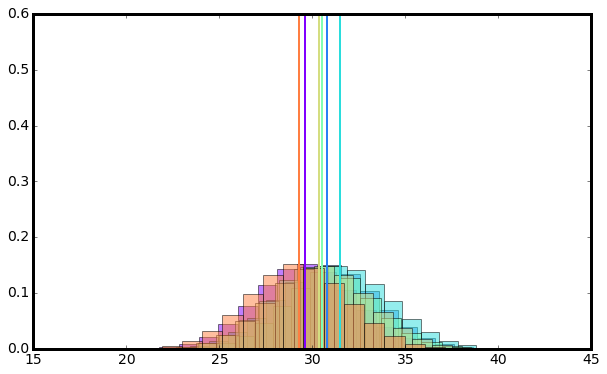

8 metastable states:
rdf-0 feat-0


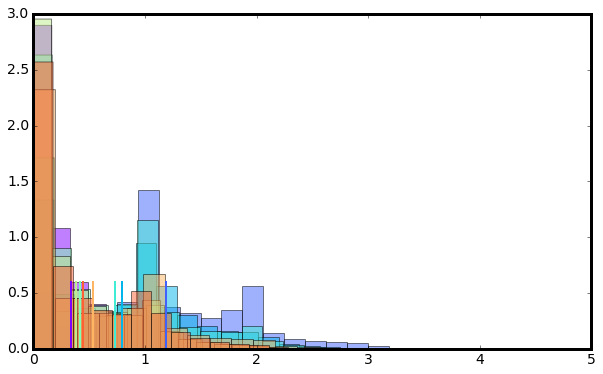

rdf-0 feat-1


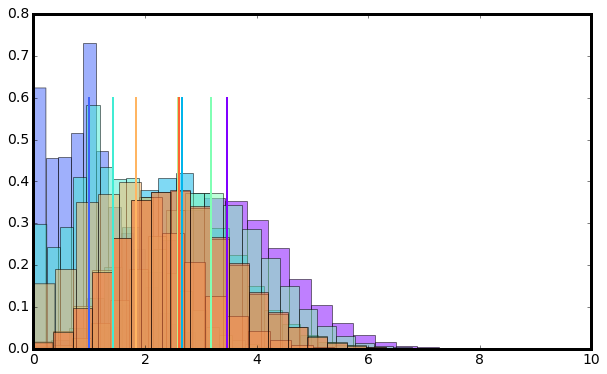

rdf-0 feat-2


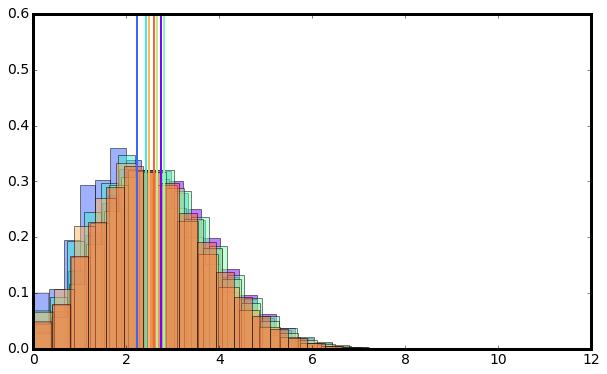

rdf-0 feat-3


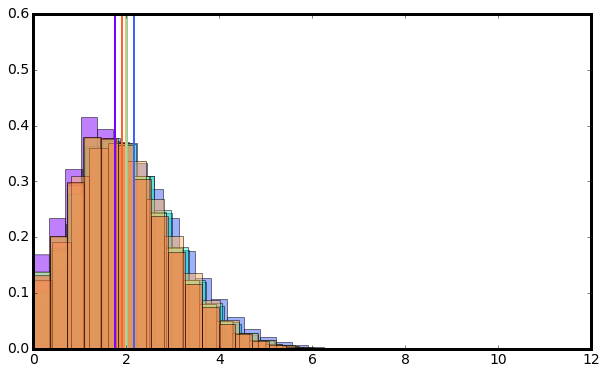

rdf-0 feat-4


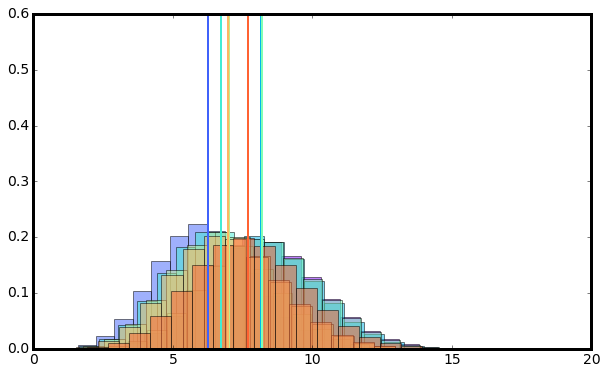

rdf-0 feat-5


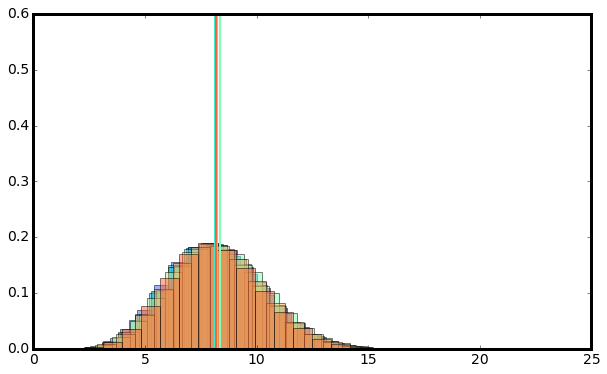

rdf-1 feat-0


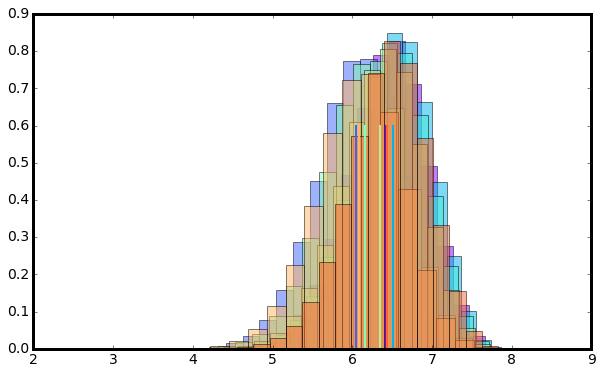

rdf-1 feat-1


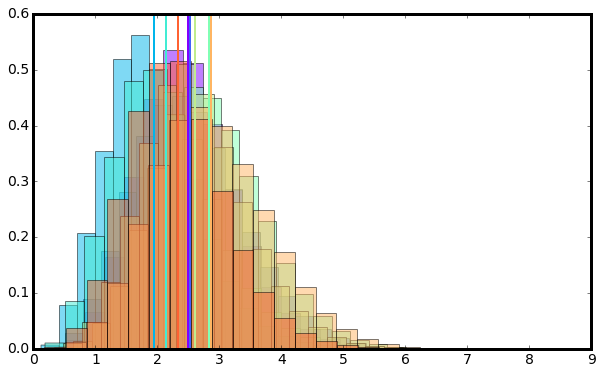

rdf-1 feat-2


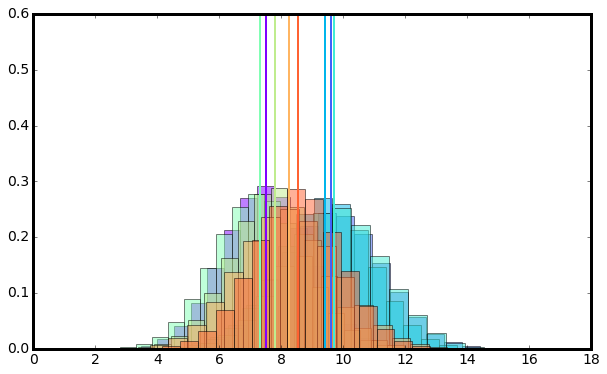

rdf-1 feat-3


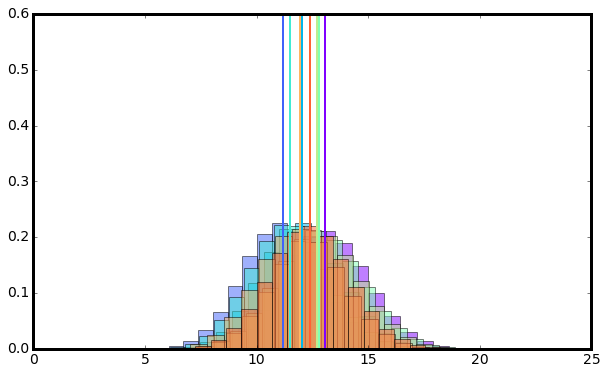

rdf-1 feat-4


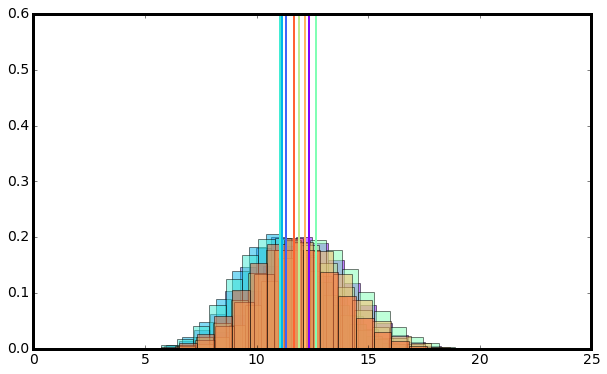

rdf-1 feat-5


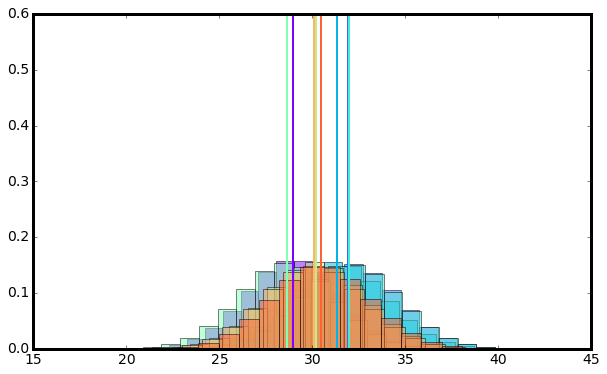

In [61]:
for nstate in range(len(N_mss)):
    print str(N_mss[nstate])+' metastable states:'

    for rdfs in range(2):
        for feat in range(6):
            print 'rdf-'+str(rdfs)+' feat-'+str(feat)
            fig = plt.figure(figsize=(10,6))
            ax = fig.add_subplot(111)
            #
            for state in range(N_mss[nstate]):
                tmp = plt.hist( np.array(CN_rdf[nstate][rdfs][feat])[state], bins=25, normed=True, alpha=0.5, color=mss_colors[nstate][state] )
                plt.plot(avg_CN[nstate][rdfs][feat][state]*np.ones(10),np.linspace(0,0.6,10),color=mss_colors[nstate][state],linewidth=2)

            ax.spines['left'].set_linewidth(3.0)
            ax.spines['right'].set_linewidth(3.0)
            ax.spines['top'].set_linewidth(3.0)
            ax.spines['bottom'].set_linewidth(3.0)
            #plt.ylabel(r'${\rm P}({\rm WCN})$',fontsize='34',fontweight='normal')
            #plt.xlabel(r'${\rm WCN}_{\rm BB}^{(1)}$',fontsize='34',labelpad=10)
            #plt.yticks(np.arange(3)*0.5,fontsize='24')
            #plt.xticks(np.arange(3),fontsize='24')
            #ax.tick_params(axis='both', which='major', pad=10)
            # legend
            #plt.legend()
            #legend = plt.legend(fontsize='26',loc='upper center', bbox_to_anchor=(1.18, 1.1))
            #frame = legend.get_frame()
            #frame.set_linewidth('3.0')
            #ltext = legend.get_texts()
            #plt.setp(ltext, fontweight='normal')
            #
            # plt.ylim([0.,0.6])
            #plt.xlim([0,2.5])
            # plt.savefig('fig_P-WCN-AA-1_7HstateHMM.svg', format='svg', dpi=800)
            # plt.savefig('fig_P-WCN-AA-1_7HstateHMM.eps', format='eps', dpi=800)
            plt.show()



In [28]:
# Now, plot the networks
lags

array([  1,   6,  11,  16,  21,  26,  31,  36,  42,  47,  52,  57,  62,
        67,  72,  78,  83,  88,  93,  98, 103, 108, 114, 119, 124, 129,
       134, 139, 144, 150])

In [26]:
# get the cored trajectories
dtraj_2state = np.load('2states/msds/dtraj_mss_2states_cored.npy')
dtraj_2state_list = []
for traj in range(len(dtraj_2state)):
    dtraj_2state_list.append(dtraj_2state[traj])
dtraj_6state = np.load('6states/msds/dtraj_mss_6states_cored.npy')
dtraj_6state_list = []
for traj in range(len(dtraj_6state)):
    dtraj_6state_list.append(dtraj_6state[traj])

In [27]:
lags = np.linspace(1,150,30,dtype=int)
#lags = np.linspace(tica_lag,8*tica_lag,tica_lag,dtype=int)
print lags
its_full = msm.timescales_msm(dtraj_2state_list, lags=lags, nits=1)

[  1   6  11  16  21  26  31  36  42  47  52  57  62  67  72  78  83  88
  93  98 103 108 114 119 124 129 134 139 144 150]


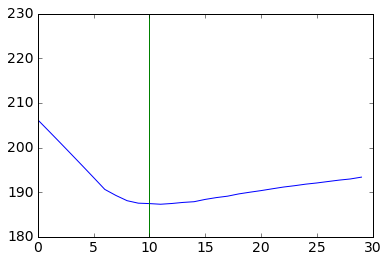

In [28]:
lag = 10
plt.plot(its_full.timescales)
plt.plot(np.ones(2)*lag, np.arange(2)*50+180)

In [29]:
msm_2state = msm.estimate_markov_model(dtraj_2state_list, lag, reversible=True)

In [30]:
# get the average position for each mss
cc = np.zeros(shape=(2,len(dtraj_2state_list),2))
for traj in range(len(dtraj_2state_list)):
    frames0 = np.where(dtraj_2state_list[traj]==0)[0]
    cc[0,traj,0] = np.mean(Y[0][traj][frames0,0])
    cc[1,traj,0] = np.mean(Y[0][traj][frames0,1])
    frames1 = np.where(dtraj_2state_list[traj]==1)[0]
    cc[0,traj,1] = np.mean(Y[0][traj][frames1,0])
    cc[1,traj,1] = np.mean(Y[0][traj][frames1,1])

In [31]:
cc_avg_2state = np.mean(cc,axis=1)
print cc_avg_2state

[[-1.66946189  0.72568523]
 [-0.75829981  0.32681764]]


In [32]:
lags = np.linspace(1,150,30,dtype=int)
#lags = np.linspace(tica_lag,8*tica_lag,tica_lag,dtype=int)
print lags
its_full = msm.timescales_msm(dtraj_6state_list, lags=lags, nits=6)

[  1   6  11  16  21  26  31  36  42  47  52  57  62  67  72  78  83  88
  93  98 103 108 114 119 124 129 134 139 144 150]
30-07-18 15:46:33 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[0] WARNING  Changed user setting nits to the number of available timescales nits=5


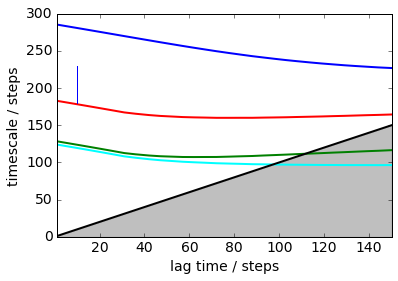

In [33]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its_full, ylog=False, units='steps', linewidth=2)
#xlim(0, 10); ylim(0, 100);
lag = 10
plt.plot(np.ones(2)*lag, np.arange(2)*50+180)

In [34]:
msm_6state = msm.estimate_markov_model(dtraj_6state_list, lag, reversible=True)

In [35]:
# get the average position for each mss
cc = np.zeros(shape=(2,len(dtraj_6state_list),6))
for traj in range(len(dtraj_2state_list)):
    for state in range(6):
        frames = np.where(dtraj_6state_list[traj]==state)[0]
        cc[0,traj,state] = np.mean(Y[0][traj][frames,0])
        cc[1,traj,state] = np.mean(Y[0][traj][frames,1])

In [36]:
cc_avg_6state = np.mean(cc,axis=1)
print cc_avg_6state

[[-1.06040901 -2.14086774 -2.1387742  -1.62249091  0.83616699  1.52542196]
 [-2.19724109 -0.0974149   1.22307334 -0.18590928  1.02245667 -0.97664489]]


In [37]:
import pickle
def save_object(filename, obj):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [38]:
save_object('MSM_'+str(2)+'state.pkl', msm_2state)
save_object('MSM_'+str(6)+'state.pkl', msm_6state)

In [39]:
# just load the HMSMs for replotting
from networks_JFR import *

In [40]:
# import pickle
# # get the models
# for nstate in range(len(N_mss)):
#     with open('HMSM_'+str(nstate)+'.pkl', 'rb') as f:
#         hmsm = pickle.load(f)

In [41]:
# now get the diff info

In [42]:
diff_info_avg = np.load('2states/msds/diff_info_avg.npz')

In [43]:
wt_avg_2states = diff_info_avg['wt_avg']
msd_avg_2states = diff_info_avg['msd_avg']
D_loc_2states = diff_info_avg['D_loc']

In [44]:
diff_info_avg = np.load('6states/msds/diff_info_avg.npz')

In [45]:
wt_avg_6states = diff_info_avg['wt_avg']
msd_avg_6states = diff_info_avg['msd_avg']
D_loc_6states = diff_info_avg['D_loc']

In [46]:
cc_avg_6state.shape

(2, 6)

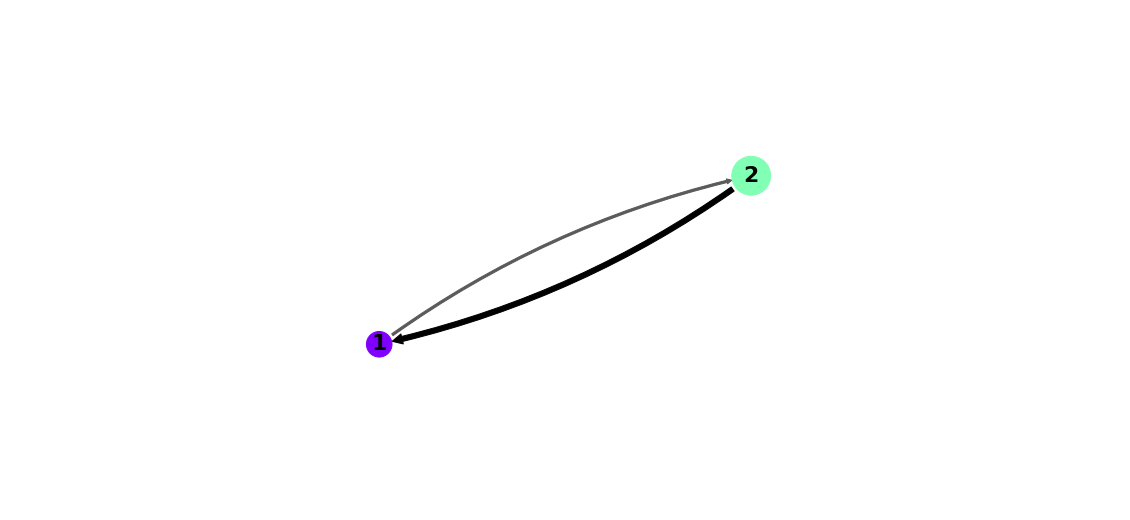

[[0.00000000e+00 2.28686709e-06]
 [5.12664822e-06 0.00000000e+00]]


In [47]:
nstate = 0

# options
minflux=1e-9
max_flux=1
arrow_labels=None 
max_width=20
max_height=15
figpadding=1
state_scale = 2
arrow_scale = 500
flux_fact = 100
flux_scale = 100
fontsize=22
fontweight='bold'

state_labels = [1,2]

fig,pos = plot_flux(D_loc_2states, state_labels=state_labels, flux_scale=flux_scale,state_sizes=msm_2state.stationary_distribution,state_colors=mss_colors[nstate], pos=cc_avg_2state.T*2., minflux=minflux, max_width=max_width, max_height=max_height, figpadding=figpadding, state_scale=state_scale, arrow_scale=arrow_scale, size=fontsize, weight=fontweight, show_committor=False, max_flux=max_flux,arrow_labels=arrow_labels)
gca().set_frame_on(False)
#plt.tight_layout()
plt.savefig('Network_2state_B-type.svg', format='svg', dpi=800, bbox_inches='tight')
plt.savefig('Network_2state_B-type.eps', format='eps', dpi=800, bbox_inches='tight')
plt.show()
print D_loc_2states

In [51]:
msm_2state.P

array([[0.96624314, 0.03375686],
       [0.01463654, 0.98536346]])

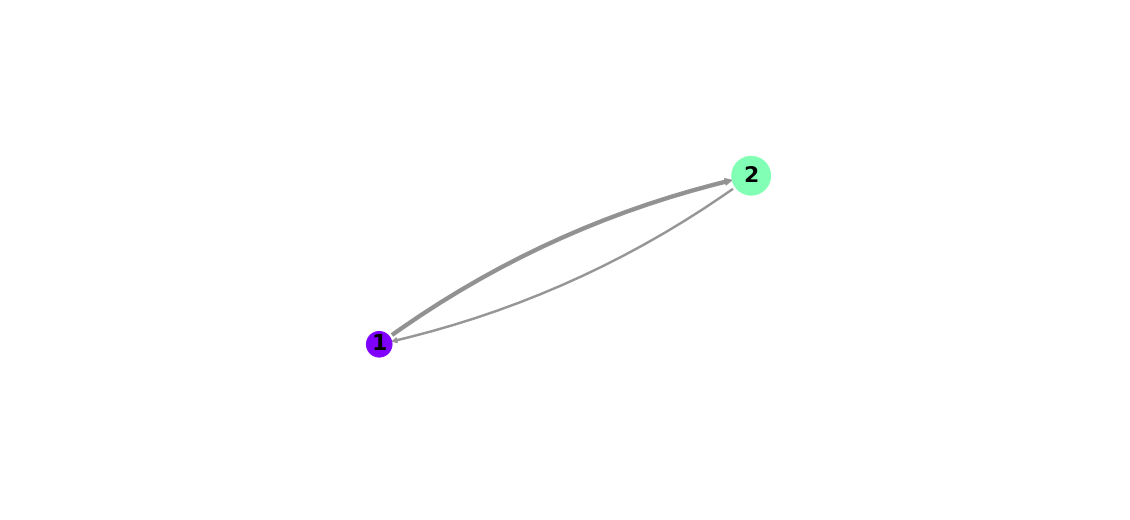

[[0.00000000e+00 2.28686709e-06]
 [5.12664822e-06 0.00000000e+00]]


In [48]:
nstate = 0

# options
minflux=1e-9
max_flux=1
arrow_labels=None 
max_width=20
max_height=15
figpadding=1
state_scale = 2
arrow_scale = 5
flux_fact = 1
flux_scale = 1
fontsize=22
fontweight='bold'

state_labels = [1,2]

fig,pos = plot_flux(msm_2state.P, state_labels=state_labels, flux_scale=flux_scale,state_sizes=msm_2state.stationary_distribution,state_colors=mss_colors[nstate], pos=cc_avg_2state.T*2., minflux=minflux, max_width=max_width, max_height=max_height, figpadding=figpadding, state_scale=state_scale, arrow_scale=arrow_scale, size=fontsize, weight=fontweight, show_committor=False, max_flux=max_flux,arrow_labels=arrow_labels)
gca().set_frame_on(False)
#plt.tight_layout()
# plt.savefig('Network_2state_B-type.svg', format='svg', dpi=800, bbox_inches='tight')
# plt.savefig('Network_2state_B-type.eps', format='eps', dpi=800, bbox_inches='tight')
plt.show()
print D_loc_2states

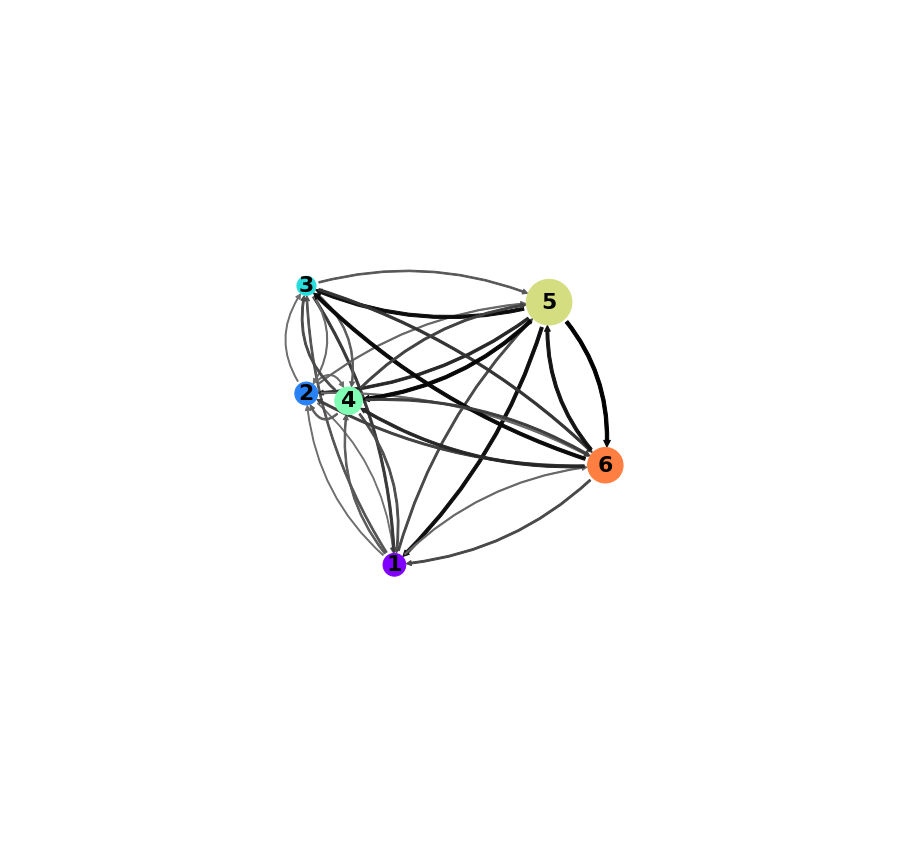

[[0.00000000e+00 1.80586411e-06 3.31079897e-06 2.96273756e-06
  3.73293006e-06 2.31489807e-06]
 [1.65303113e-06 0.00000000e+00 1.84665197e-06 1.98516346e-06
  2.37491239e-06 2.28832582e-06]
 [4.30104240e-06 2.06604418e-06 0.00000000e+00 2.90629564e-06
  3.10175360e-06 4.48174345e-06]
 [3.54933723e-06 2.84143984e-06 3.62948433e-06 0.00000000e+00
  3.94272129e-06 4.08790694e-06]
 [6.02658587e-06 4.94227576e-06 6.17374886e-06 6.34216880e-06
  0.00000000e+00 6.67360116e-06]
 [3.71698183e-06 3.97949184e-06 6.17919768e-06 4.93048388e-06
  5.83169824e-06 0.00000000e+00]]


In [49]:
nstate = 0

# options
minflux=1e-9
max_flux=1
arrow_labels=None 
max_width=20
max_height=15
figpadding=1
state_scale = 30
arrow_scale = 500
flux_fact = 100
flux_scale = 50
fontsize=22
fontweight='bold'

state_labels = [1,2,3,4,5,6]

fig,pos = plot_flux(D_loc_6states, state_labels=state_labels, flux_scale=flux_scale,state_sizes=msm_6state.stationary_distribution,state_colors=mss_colors[4], pos=cc_avg_6state.T*2., minflux=minflux, max_width=max_width, max_height=max_height, figpadding=figpadding, state_scale=state_scale, arrow_scale=arrow_scale, size=fontsize, weight=fontweight, show_committor=False, max_flux=max_flux,arrow_labels=arrow_labels)
gca().set_frame_on(False)
#plt.tight_layout()
plt.savefig('Network_6state_B-type.svg', format='svg', dpi=800, bbox_inches='tight')
plt.savefig('Network_6state_B-type.eps', format='eps', dpi=800, bbox_inches='tight')
plt.show()
print D_loc_6states

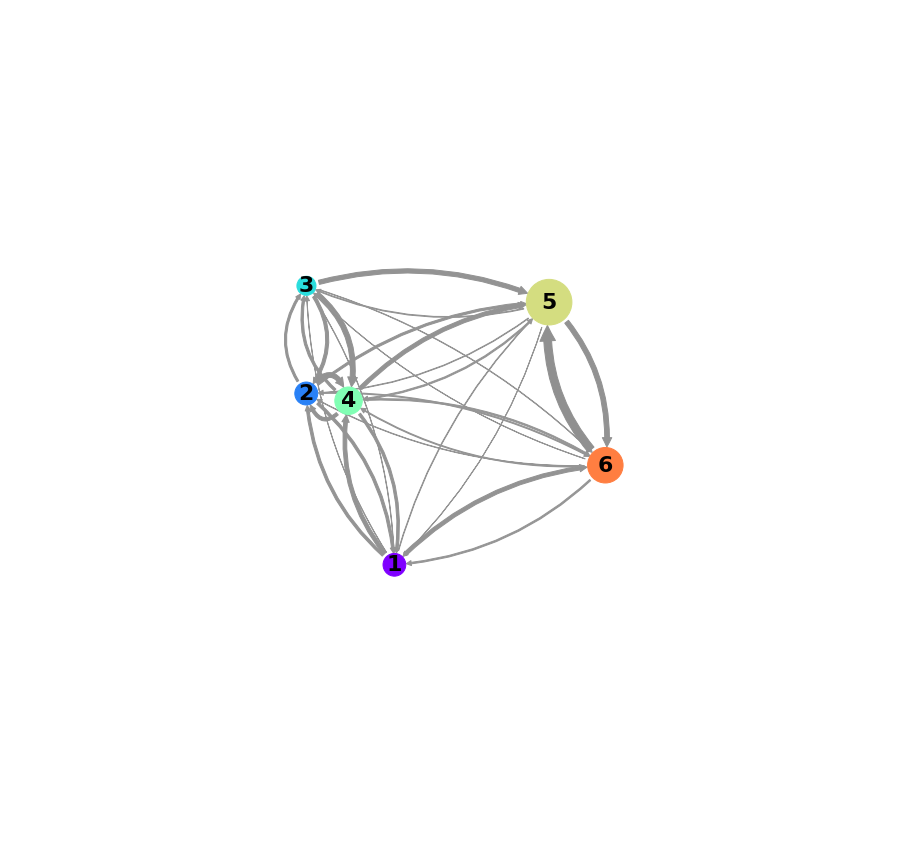

[[0.00000000e+00 1.80586411e-06 3.31079897e-06 2.96273756e-06
  3.73293006e-06 2.31489807e-06]
 [1.65303113e-06 0.00000000e+00 1.84665197e-06 1.98516346e-06
  2.37491239e-06 2.28832582e-06]
 [4.30104240e-06 2.06604418e-06 0.00000000e+00 2.90629564e-06
  3.10175360e-06 4.48174345e-06]
 [3.54933723e-06 2.84143984e-06 3.62948433e-06 0.00000000e+00
  3.94272129e-06 4.08790694e-06]
 [6.02658587e-06 4.94227576e-06 6.17374886e-06 6.34216880e-06
  0.00000000e+00 6.67360116e-06]
 [3.71698183e-06 3.97949184e-06 6.17919768e-06 4.93048388e-06
  5.83169824e-06 0.00000000e+00]]


In [54]:
nstate = 0

# options
minflux=1e-9
max_flux=1
arrow_labels=None 
max_width=20
max_height=15
figpadding=1
state_scale = 30
arrow_scale = 5
flux_fact = 1
flux_scale = 2
fontsize=22
fontweight='bold'

state_labels = [1,2,3,4,5,6]

fig,pos = plot_flux(msm_6state.P, state_labels=state_labels, flux_scale=flux_scale,state_sizes=msm_6state.stationary_distribution,state_colors=mss_colors[4], pos=cc_avg_6state.T*2., minflux=minflux, max_width=max_width, max_height=max_height, figpadding=figpadding, state_scale=state_scale, arrow_scale=arrow_scale, size=fontsize, weight=fontweight, show_committor=False, max_flux=max_flux,arrow_labels=arrow_labels)
gca().set_frame_on(False)
#plt.tight_layout()
# plt.savefig('Network_6state_B-type.svg', format='svg', dpi=800, bbox_inches='tight')
# plt.savefig('Network_6state_B-type.eps', format='eps', dpi=800, bbox_inches='tight')
plt.show()
print D_loc_6states